In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
project_dir = '/content/drive/MyDrive/PPO_Pong_Project_v2'
os.makedirs(project_dir, exist_ok=True)
os.makedirs(f'{project_dir}/models', exist_ok=True)
os.makedirs(f'{project_dir}/metrics', exist_ok=True)
os.makedirs(f'{project_dir}/visualizations', exist_ok=True)
os.makedirs(f'{project_dir}/logs', exist_ok=True)

Mounted at /content/drive


In [ ]:
!pip install -q gymnasium[atari,accept-rom-license] stable-baselines3[extra] ale-py wandb

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 15.1 MB/s eta 0:00:00
PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB


In [ ]:
import wandb
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sp3 (sp3-university-of-arizona) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
import numpy as np
import json
import ale_py
import gymnasium as gym
from datetime import datetime
from collections import defaultdict
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv, VecMonitor, VecTransposeImage
from stable_baselines3.common.atari_wrappers import AtariWrapper
from stable_baselines3.common.callbacks import BaseCallback, CheckpointCallback
import matplotlib.pyplot as plt

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
class WandBMetricsCallback(BaseCallback):
    """
    Enhanced callback that:
    1. Logs episode returns to WandB automatically
    2. Tracks steps to reach target return
    3. Saves periodic metrics to JSON as backup
    """
    def __init__(self, save_path, target_return=18.0, save_freq=50000, verbose=1):
        super().__init__(verbose)
        self.save_path = save_path
        self.target_return = target_return
        self.save_freq = save_freq

        # episode tracking
        self.episode_returns = []
        self.episode_lengths = []
        self.timesteps = []

        # target tracking
        self.target_reached = False
        self.steps_to_target = None
        self.episodes_completed = 0

        self.recent_returns = []
        self.window_size = 50

    def _on_step(self):
        # check for completed episodes in all parallel envs
        infos = self.locals.get('infos', [])

        for info in infos:
            if 'episode' in info:
                ep_return = info['episode']['r']
                ep_length = info['episode']['l']

                self.episode_returns.append(float(ep_return))
                self.episode_lengths.append(int(ep_length))
                self.timesteps.append(int(self.num_timesteps))
                self.episodes_completed += 1

                self.recent_returns.append(ep_return)
                if len(self.recent_returns) > self.window_size:
                    self.recent_returns.pop(0)

                wandb.log({
                    "episode/return": ep_return,
                    "episode/length": ep_length,
                    "episode/return_ma50": np.mean(self.recent_returns),
                    "episode/count": self.episodes_completed,
                    "timestep": self.num_timesteps
                })

                # check target
                if not self.target_reached and ep_return >= self.target_return:
                    self.target_reached = True
                    self.steps_to_target = self.num_timesteps
                    wandb.log({"target_reached_at_step": self.num_timesteps})
                    if self.verbose > 0:
                        print(f"target reached at {self.num_timesteps:,} steps return: {ep_return:.2f}")

        # periodic save to JSON for backup
        if self.num_timesteps % self.save_freq == 0:
            self._save_metrics()

        return True

    def _save_metrics(self):
        metrics = {
            'results': {
                'timesteps_so_far': self.num_timesteps,
                'episodes_completed': self.episodes_completed,
                'target_reached': self.target_reached,
                'steps_to_target': self.steps_to_target,
                'mean_return': float(np.mean(self.episode_returns)) if self.episode_returns else 0.0,
                'std_return': float(np.std(self.episode_returns)) if self.episode_returns else 0.0,
            },
            'episode_data': {
                'returns': self.episode_returns,
                'lengths': self.episode_lengths,
                'timesteps': self.timesteps,
            }
        }

        with open(self.save_path, 'w') as f:
            json.dump(metrics, f, indent=2)

    def _on_training_end(self):
        self._save_metrics()
        print(f"total episodes: {self.episodes_completed}")
        print(f"target reached: {self.target_reached}")
        if self.steps_to_target:
            print(f"steps to target: {self.steps_to_target:,}")

In [ ]:
def train_custom_ppo(
    seed=42,
    total_timesteps=10_000_000,
    n_envs=8,
    target_return=18.0,
    use_wandb=True,
    experiment_name="custom"
):
    run_name = f"{experiment_name}_seed{seed}"
    print(f"Training: {run_name}")
    print(f"Seed: {seed} | Timesteps: {total_timesteps:,} | Envs: {n_envs}")

    # initialize WandB run
    if use_wandb:
        wandb.init(
            project="csc496-ppo-pong",
            name=run_name,
            config={
                "seed": seed,
                "total_timesteps": total_timesteps,
                "n_envs": n_envs,
                "target_return": target_return,
                "experiment": experiment_name,
                # PPO hyperparams
                "learning_rate": 2.5e-4,
                "n_steps": 128,
                "batch_size": 256,
                "n_epochs": 4,
                "gamma": 0.99,
                "gae_lambda": 0.95,
                "clip_range": "0.2→0.05 decay",
                "ent_coef": 0.02,
                "vf_coef": 0.5,
                "target_kl": 0.015,
            },
            reinit=True
        )

    # create environment
    def make_env(seed_offset=0):
        def _init():
            env = gym.make("ALE/Pong-v5")
            env = AtariWrapper(env)
            env.reset(seed=seed + seed_offset)
            return env
        return _init

    env = DummyVecEnv([make_env(i) for i in range(n_envs)])
    env = VecFrameStack(env, n_stack=4)
    env = VecTransposeImage(env)
    env = VecMonitor(env)

    # setup TensorBoard logging
    tb_log_dir = f"{project_dir}/logs/{run_name}"

    # create PPO model
    model = PPO(
        policy="CnnPolicy",
        env=env,
        learning_rate=2.5e-4,
        n_steps=128,
        batch_size=256,
        n_epochs=4,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=lambda p: 0.2 - 0.15*p,
        ent_coef=0.02,
        target_kl=0.015,
        vf_coef=0.5,
        max_grad_norm=0.5,
        verbose=1,
        seed=seed,
        tensorboard_log=tb_log_dir,
    )

    # setup callbacks
    metrics_callback = WandBMetricsCallback(
        save_path=f"{project_dir}/metrics/{run_name}_metrics.json",
        target_return=target_return,
        save_freq=100_000,
        verbose=1,
    )

    checkpoint_callback = CheckpointCallback(
        save_freq=500_000 // n_envs,
        save_path=f"{project_dir}/models/{run_name}",
        name_prefix="ppo_pong",
    )

    # train
    print("starting training")
    start_time = datetime.now()

    model.learn(
        total_timesteps=total_timesteps,
        callback=[metrics_callback, checkpoint_callback],
        progress_bar=True,
    )

    duration = datetime.now() - start_time

    # save final model
    model_path = f"{project_dir}/models/{run_name}/final_model"
    model.save(model_path)

    # log final stats to WandB
    if use_wandb:
        wandb.log({
            "training_time_hours": duration.total_seconds() / 3600,
            "final_episodes": metrics_callback.episodes_completed,
            "final_mean_return": np.mean(metrics_callback.episode_returns) if metrics_callback.episode_returns else 0,
        })

    print(f"training complete duration: {duration}")
    print(f"Model saved to: {model_path}")

    env.close()

    if use_wandb:
        wandb.finish()

    return model, model_path, metrics_callback

In [ ]:
def evaluate_model_full(model_path, n_episodes=20, seed=999):
    """
    evaluation that collects:
    - Episode returns
    - Value function estimates (for heatmap)
    - Policy entropy (for heatmap)
    - Action distribution
    """

    # create eval environment
    def make_eval_env():
        def _init():
            env = gym.make("ALE/Pong-v5")
            env = AtariWrapper(env)
            env.reset(seed=seed)
            return env
        return _init

    eval_env = DummyVecEnv([make_eval_env()])
    eval_env = VecFrameStack(eval_env, n_stack=4)
    eval_env = VecTransposeImage(eval_env)

    model = PPO.load(model_path)

    # data collection
    eval_returns = []
    eval_lengths = []
    value_grid = defaultdict(list)
    entropy_grid = defaultdict(list)
    action_counts = defaultdict(int)

    for ep in range(n_episodes):
        obs = eval_env.reset()
        done = False
        ep_return = 0
        step_count = 0

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            action_int = int(action[0])

            # get value and entropy from policy
            obs_tensor = torch.FloatTensor(obs).to(model.device)

            with torch.no_grad():
                features = model.policy.extract_features(obs_tensor)
                if hasattr(model.policy, 'pi_features_extractor'):
                    # separate feature extractors
                    latent_pi = model.policy.mlp_extractor.forward_actor(features)
                    latent_vf = model.policy.mlp_extractor.forward_critic(features)
                else:
                    # shared feature extractor
                    latent_pi, latent_vf = model.policy.mlp_extractor(features)

                value = model.policy.value_net(latent_vf).cpu().numpy()[0, 0]
                logits = model.policy.action_net(latent_pi)
                probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
                entropy = -np.sum(probs * np.log(probs + 1e-8))

            # bin by step position
            x_bin = step_count % 10
            y_bin = (step_count // 10) % 10
            value_grid[(x_bin, y_bin)].append(value)
            entropy_grid[(x_bin, y_bin)].append(entropy)

            # track action
            action_counts[action_int] += 1

            # step
            obs, reward, done, info = eval_env.step(action)
            ep_return += reward[0]
            step_count += 1

        eval_returns.append(ep_return)
        eval_lengths.append(step_count)
        print(f"episode {ep+1:2d}/{n_episodes}: Return = {ep_return:6.1f} | Steps = {step_count}")

    eval_env.close()

    results = {
        'returns': eval_returns,
        'lengths': eval_lengths,
        'mean_return': np.mean(eval_returns),
        'std_return': np.std(eval_returns),
        'median_return': np.median(eval_returns),
        'min_return': np.min(eval_returns),
        'max_return': np.max(eval_returns),
        'value_grid': dict(value_grid),
        'entropy_grid': dict(entropy_grid),
        'action_counts': dict(action_counts),
    }

    print(f"Evaluation Results ({n_episodes} episodes):")
    print(f"Mean return: {results['mean_return']:.2f} ± {results['std_return']:.2f}")
    print(f"Median return: {results['median_return']:.2f}")
    print(f"Range: [{results['min_return']:.0f}, {results['max_return']:.0f}]")

    return results

In [ ]:
def plot_evaluation_results(eval_results, seed, experiment_name="baseline"):
    """
    1. Return distribution histogram
    2. Value function heatmap
    3. Policy entropy heatmap
    4. Action distribution
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # return distribution
    ax = axes[0, 0]
    ax.hist(eval_results['returns'], bins=15, edgecolor='black', alpha=0.7, color='steelblue')
    ax.axvline(eval_results['mean_return'], color='r', linestyle='--', linewidth=2, label='Mean')
    ax.set_xlabel('Return', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title('Evaluation Return Distribution', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

    # value function heatmap
    ax = axes[0, 1]
    value_matrix = np.zeros((10, 10))
    for key, vals in eval_results['value_grid'].items():
        if isinstance(key, str):
            x, y = eval(key)  # Handle string keys from JSON
        else:
            x, y = key
        if 0 <= x < 10 and 0 <= y < 10:
            value_matrix[y, x] = np.mean(vals)
    im = ax.imshow(value_matrix, cmap='RdYlGn', aspect='auto')
    ax.set_title('Value Function Heatmap', fontsize=12, fontweight='bold')
    ax.set_xlabel('Step Bin (x)', fontsize=11)
    ax.set_ylabel('Step Bin (y)', fontsize=11)
    plt.colorbar(im, ax=ax, label='Mean V(s)')

    # policy entropy heatmap
    ax = axes[1, 0]
    entropy_matrix = np.zeros((10, 10))
    for key, ents in eval_results['entropy_grid'].items():
        if isinstance(key, str):
            x, y = eval(key)
        else:
            x, y = key
        if 0 <= x < 10 and 0 <= y < 10:
            entropy_matrix[y, x] = np.mean(ents)
    im = ax.imshow(entropy_matrix, cmap='viridis', aspect='auto')
    ax.set_title('Policy Entropy Heatmap', fontsize=12, fontweight='bold')
    ax.set_xlabel('Step Bin (x)', fontsize=11)
    ax.set_ylabel('Step Bin (y)', fontsize=11)
    plt.colorbar(im, ax=ax, label='Mean Entropy')

    # action distribution
    ax = axes[1, 1]
    action_names = ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
    actions = sorted(eval_results['action_counts'].keys())
    counts = [eval_results['action_counts'][a] for a in actions]
    labels = [action_names[int(a)] if int(a) < len(action_names) else f'A{a}' for a in actions]
    bars = ax.bar(labels, counts, color='coral', edgecolor='black')
    ax.set_title('Action Distribution', fontsize=12, fontweight='bold')
    ax.set_ylabel('Count', fontsize=11)
    ax.set_xlabel('Action', fontsize=11)
    plt.xticks(rotation=45)
    ax.grid(alpha=0.3, axis='y')

    plt.tight_layout()
    save_path = f"{project_dir}/visualizations/{experiment_name}_eval_seed{seed}.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved: {save_path}")
    plt.show()


def plot_learning_curve(metrics_path, seed, experiment_name="baseline"):
    """
    Plot learning curve from saved metrics JSON.
    """
    with open(metrics_path, 'r') as f:
        metrics = json.load(f)

    returns = metrics['episode_data']['returns']
    timesteps = metrics['episode_data']['timesteps']

    fig, ax = plt.subplots(figsize=(14, 6))

    # scatter plot of episode returns
    ax.scatter(timesteps, returns, alpha=0.3, s=10, label='Episode returns', color='steelblue')

    # moving average
    window = min(50, len(returns) // 2) if len(returns) > 1 else 1
    if len(returns) >= window and window > 0:
        moving_avg = np.convolve(returns, np.ones(window)/window, mode='valid')
        moving_timesteps = timesteps[window-1:]
        ax.plot(moving_timesteps, moving_avg, 'r-', linewidth=2, label=f'{window}-episode MA')

    ax.axhline(y=18, color='g', linestyle='--', linewidth=2, label='Target (18)')
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

    ax.set_xlabel('Environment Steps', fontsize=12)
    ax.set_ylabel('Episode Return', fontsize=12)
    ax.set_title(f'Learning Curve - {experiment_name.upper()} PPO (Seed {seed})', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(alpha=0.3)
    ax.set_ylim(-22, 22)

    plt.tight_layout()
    save_path = f"{project_dir}/visualizations/{experiment_name}_learning_curve_seed{seed}.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved: {save_path}")
    plt.show()


def plot_multi_seed_learning_curves(seeds, experiment_name="baseline"):
    """
    Plot learning curves from all seeds on one figure.
    """
    fig, ax = plt.subplots(figsize=(14, 6))
    colors = plt.cm.tab10(np.linspace(0, 1, len(seeds)))

    for i, seed in enumerate(seeds):
        metrics_file = f"{project_dir}/metrics/{experiment_name}_seed{seed}_metrics.json"
        if os.path.exists(metrics_file):
            with open(metrics_file, 'r') as f:
                data = json.load(f)

            timesteps = data['episode_data']['timesteps']
            returns = data['episode_data']['returns']

            ax.scatter(timesteps, returns, alpha=0.1, s=1, color=colors[i])

            # Moving average
            if len(returns) >= 50:
                window = 50
                ma = np.convolve(returns, np.ones(window)/window, mode='valid')
                ma_timesteps = timesteps[window-1:]
                ax.plot(ma_timesteps, ma, label=f'Seed {seed} (MA50)', color=colors[i], linewidth=2)

    ax.axhline(y=18, color='green', linestyle='--', label='Target (18)', linewidth=2)
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

    ax.set_xlabel('Environment Steps', fontsize=12)
    ax.set_ylabel('Episode Return', fontsize=12)
    ax.set_title(f'Learning Curves - {experiment_name.upper()} PPO (All Seeds)', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-22, 22)

    plt.tight_layout()
    save_path = f"{project_dir}/visualizations/{experiment_name}_learning_curves_all.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved: {save_path}")
    plt.show()

In [ ]:
SEEDS = [42, 43, 44]
TOTAL_TIMESTEPS = 3_000_000
N_ENVS = 8
TARGET_RETURN = 18.0

Training: custom_seed42
Seed: 42 | Timesteps: 3,000,000 | Envs: 8


/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py:279: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


Using cuda device
starting training
Logging to /content/drive/MyDrive/PPO_Pong_Project_v2/logs/custom_seed42/PPO_1


Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Streaming output truncated to the last 5000 lines.
|    value_loss           | 0.288       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 840         |
|    ep_rew_mean          | -13.4       |
| time/                   |             |
|    fps                  | 281         |
|    iterations           | 1517        |
|    time_elapsed         | 5518        |
|    total_timesteps      | 1553408     |
| train/                  |             |
|    approx_kl            | 0.007315754 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.128       |
|    entropy_loss         | -0.9        |
|    explained_variance   | 0.557       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0602      |
|    n_updates            | 6064        |
|    policy_gradient_loss | -0.0062     |
|    value_loss           | 0.206       |
-------------------------

Early stopping at step 3 due to reaching max kl: 0.03

Streaming output truncated to the last 5000 lines.
|    value_loss           | 0.182       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+03    |
|    ep_rew_mean          | -4.8        |
| time/                   |             |
|    fps                  | 279         |
|    iterations           | 2108        |
|    time_elapsed         | 7709        |
|    total_timesteps      | 2158592     |
| train/                  |             |
|    approx_kl            | 0.009127258 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.158       |
|    entropy_loss         | -0.997      |
|    explained_variance   | 0.567       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0334      |
|    n_updates            | 8428        |
|    policy_gradient_loss | -0.0131     |
|    value_loss           | 0.213       |
-------------------------

Early stopping at step 2 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 963         |
|    ep_rew_mean          | -6.47       |
| time/                   |             |
|    fps                  | 280         |
|    iterations           | 2346        |
|    time_elapsed         | 8579        |
|    total_timesteps      | 2402304     |
| train/                  |             |
|    approx_kl            | 0.022532457 |
|    clip_fraction        | 0.0965      |
|    clip_range           | 0.17        |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.557       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0914      |
|    n_updates            | 9379        |
|    policy_gradient_loss | -0.00892    |
|    value_loss           | 0.273       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 971   

Early stopping at step 2 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 986         |
|    ep_rew_mean          | -5.87       |
| time/                   |             |
|    fps                  | 280         |
|    iterations           | 2360        |
|    time_elapsed         | 8630        |
|    total_timesteps      | 2416640     |
| train/                  |             |
|    approx_kl            | 0.017761365 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.171       |
|    entropy_loss         | -1.07       |
|    explained_variance   | 0.587       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.037       |
|    n_updates            | 9434        |
|    policy_gradient_loss | -0.0108     |
|    value_loss           | 0.226       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 985   

Early stopping at step 2 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -5.48       |
| time/                   |             |
|    fps                  | 280         |
|    iterations           | 2372        |
|    time_elapsed         | 8674        |
|    total_timesteps      | 2428928     |
| train/                  |             |
|    approx_kl            | 0.021270076 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.171       |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.501       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.132       |
|    n_updates            | 9481        |
|    policy_gradient_loss | -0.00989    |
|    value_loss           | 0.335       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03 

Early stopping at step 2 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 997         |
|    ep_rew_mean          | -6.26       |
| time/                   |             |
|    fps                  | 279         |
|    iterations           | 2477        |
|    time_elapsed         | 9059        |
|    total_timesteps      | 2536448     |
| train/                  |             |
|    approx_kl            | 0.023495227 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.177       |
|    entropy_loss         | -1.06       |
|    explained_variance   | 0.548       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0732      |
|    n_updates            | 9900        |
|    policy_gradient_loss | -0.00911    |
|    value_loss           | 0.218       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 996   

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.01e+03    |
|    ep_rew_mean          | -5.64       |
| time/                   |             |
|    fps                  | 279         |
|    iterations           | 2504        |
|    time_elapsed         | 9157        |
|    total_timesteps      | 2564096     |
| train/                  |             |
|    approx_kl            | 0.016416807 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.178       |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.547       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0438      |
|    n_updates            | 10008       |
|    policy_gradient_loss | -0.0165     |
|    value_loss           | 0.228       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.01e+

Early stopping at step 3 due to reaching max kl: 0.02

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.02e+03   |
|    ep_rew_mean          | -5.15      |
| time/                   |            |
|    fps                  | 280        |
|    iterations           | 2542       |
|    time_elapsed         | 9296       |
|    total_timesteps      | 2603008    |
| train/                  |            |
|    approx_kl            | 0.01814163 |
|    clip_fraction        | 0.0938     |
|    clip_range           | 0.18       |
|    entropy_loss         | -1.11      |
|    explained_variance   | 0.344      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.114      |
|    n_updates            | 10160      |
|    policy_gradient_loss | -0.0119    |
|    value_loss           | 0.373      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.01e+03    |
|    ep_rew_m

Early stopping at step 2 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.04e+03    |
|    ep_rew_mean          | -3.64       |
| time/                   |             |
|    fps                  | 280         |
|    iterations           | 2593        |
|    time_elapsed         | 9482        |
|    total_timesteps      | 2655232     |
| train/                  |             |
|    approx_kl            | 0.012817943 |
|    clip_fraction        | 0.0632      |
|    clip_range           | 0.183       |
|    entropy_loss         | -1.12       |
|    explained_variance   | 0.444       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.105       |
|    n_updates            | 10363       |
|    policy_gradient_loss | -0.00755    |
|    value_loss           | 0.286       |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.04

Early stopping at step 2 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.04e+03    |
|    ep_rew_mean          | -4.06       |
| time/                   |             |
|    fps                  | 280         |
|    iterations           | 2600        |
|    time_elapsed         | 9507        |
|    total_timesteps      | 2662400     |
| train/                  |             |
|    approx_kl            | 0.016195104 |
|    clip_fraction        | 0.0898      |
|    clip_range           | 0.183       |
|    entropy_loss         | -1.02       |
|    explained_variance   | 0.581       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0324      |
|    n_updates            | 10390       |
|    policy_gradient_loss | -0.0129     |
|    value_loss           | 0.173       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.04e+

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+03    |
|    ep_rew_mean          | -4          |
| time/                   |             |
|    fps                  | 280         |
|    iterations           | 2639        |
|    time_elapsed         | 9649        |
|    total_timesteps      | 2702336     |
| train/                  |             |
|    approx_kl            | 0.023574179 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.185       |
|    entropy_loss         | -1.04       |
|    explained_variance   | 0.651       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0162      |
|    n_updates            | 10546       |
|    policy_gradient_loss | -0.0134     |
|    value_loss           | 0.159       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+

Early stopping at step 2 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.07e+03    |
|    ep_rew_mean          | -3.95       |
| time/                   |             |
|    fps                  | 280         |
|    iterations           | 2645        |
|    time_elapsed         | 9671        |
|    total_timesteps      | 2708480     |
| train/                  |             |
|    approx_kl            | 0.016901866 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.185       |
|    entropy_loss         | -1.04       |
|    explained_variance   | 0.365       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.127       |
|    n_updates            | 10569       |
|    policy_gradient_loss | -0.00919    |
|    value_loss           | 0.328       |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.07e+03

Early stopping at step 3 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.07e+03    |
|    ep_rew_mean          | -3.63       |
| time/                   |             |
|    fps                  | 280         |
|    iterations           | 2649        |
|    time_elapsed         | 9686        |
|    total_timesteps      | 2712576     |
| train/                  |             |
|    approx_kl            | 0.020365389 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.186       |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.702       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0228      |
|    n_updates            | 10585       |
|    policy_gradient_loss | -0.018      |
|    value_loss           | 0.188       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.07e+

target reached at 2,738,472 steps return: 19.00

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.07e+03    |
|    ep_rew_mean          | -3.5        |
| time/                   |             |
|    fps                  | 280         |
|    iterations           | 2675        |
|    time_elapsed         | 9780        |
|    total_timesteps      | 2739200     |
| train/                  |             |
|    approx_kl            | 0.014905736 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.187       |
|    entropy_loss         | -1.04       |
|    explained_variance   | 0.607       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0695      |
|    n_updates            | 10689       |
|    policy_gradient_loss | -0.0167     |
|    value_loss           | 0.266       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.07e+

Early stopping at step 2 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.07e+03    |
|    ep_rew_mean          | -3.42       |
| time/                   |             |
|    fps                  | 280         |
|    iterations           | 2683        |
|    time_elapsed         | 9810        |
|    total_timesteps      | 2747392     |
| train/                  |             |
|    approx_kl            | 0.016714707 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.187       |
|    entropy_loss         | -0.966      |
|    explained_variance   | 0.608       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.109       |
|    n_updates            | 10720       |
|    policy_gradient_loss | -0.0127     |
|    value_loss           | 0.326       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.07e+

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+03    |
|    ep_rew_mean          | -2.21       |
| time/                   |             |
|    fps                  | 280         |
|    iterations           | 2712        |
|    time_elapsed         | 9916        |
|    total_timesteps      | 2777088     |
| train/                  |             |
|    approx_kl            | 0.016394332 |
|    clip_fraction        | 0.0826      |
|    clip_range           | 0.189       |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.547       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0613      |
|    n_updates            | 10836       |
|    policy_gradient_loss | -0.0136     |
|    value_loss           | 0.277       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.07e+03    |
|    ep_rew_mean          | -2.1        |
| time/                   |             |
|    fps                  | 280         |
|    iterations           | 2720        |
|    time_elapsed         | 9946        |
|    total_timesteps      | 2785280     |
| train/                  |             |
|    approx_kl            | 0.020349149 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.189       |
|    entropy_loss         | -1.04       |
|    explained_variance   | 0.639       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0484      |
|    n_updates            | 10868       |
|    policy_gradient_loss | -0.0157     |
|    value_loss           | 0.23        |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.06e+03

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+03    |
|    ep_rew_mean          | -1          |
| time/                   |             |
|    fps                  | 280         |
|    iterations           | 2761        |
|    time_elapsed         | 10096       |
|    total_timesteps      | 2827264     |
| train/                  |             |
|    approx_kl            | 0.015385033 |
|    clip_fraction        | 0.0903      |
|    clip_range           | 0.191       |
|    entropy_loss         | -1.06       |
|    explained_variance   | 0.599       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0252      |
|    n_updates            | 11032       |
|    policy_gradient_loss | -0.0139     |
|    value_loss           | 0.185       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+

Early stopping at step 2 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+03    |
|    ep_rew_mean          | -1.45       |
| time/                   |             |
|    fps                  | 280         |
|    iterations           | 2780        |
|    time_elapsed         | 10166       |
|    total_timesteps      | 2846720     |
| train/                  |             |
|    approx_kl            | 0.016777128 |
|    clip_fraction        | 0.0849      |
|    clip_range           | 0.192       |
|    entropy_loss         | -1.11       |
|    explained_variance   | 0.386       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.2         |
|    n_updates            | 11107       |
|    policy_gradient_loss | -0.00718    |
|    value_loss           | 0.448       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+

Early stopping at step 3 due to reaching max kl: 0.02

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.06e+03   |
|    ep_rew_mean          | -2.23      |
| time/                   |            |
|    fps                  | 279        |
|    iterations           | 2805       |
|    time_elapsed         | 10259      |
|    total_timesteps      | 2872320    |
| train/                  |            |
|    approx_kl            | 0.01724647 |
|    clip_fraction        | 0.112      |
|    clip_range           | 0.194      |
|    entropy_loss         | -1.07      |
|    explained_variance   | 0.67       |
|    learning_rate        | 0.00025    |
|    loss                 | 0.032      |
|    n_updates            | 11207      |
|    policy_gradient_loss | -0.022     |
|    value_loss           | 0.254      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+03    |
|    ep_rew_m

Early stopping at step 3 due to reaching max kl: 0.02

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.04e+03   |
|    ep_rew_mean          | -2.83      |
| time/                   |            |
|    fps                  | 279        |
|    iterations           | 2810       |
|    time_elapsed         | 10277      |
|    total_timesteps      | 2877440    |
| train/                  |            |
|    approx_kl            | 0.01903035 |
|    clip_fraction        | 0.134      |
|    clip_range           | 0.194      |
|    entropy_loss         | -1.01      |
|    explained_variance   | 0.621      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.0273     |
|    n_updates            | 11227      |
|    policy_gradient_loss | -0.0154    |
|    value_loss           | 0.19       |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.04e+03    |
|    ep_rew_m

Early stopping at step 2 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.04e+03    |
|    ep_rew_mean          | -2.86       |
| time/                   |             |
|    fps                  | 279         |
|    iterations           | 2818        |
|    time_elapsed         | 10306       |
|    total_timesteps      | 2885632     |
| train/                  |             |
|    approx_kl            | 0.020945905 |
|    clip_fraction        | 0.077       |
|    clip_range           | 0.194       |
|    entropy_loss         | -1.03       |
|    explained_variance   | 0.337       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0862      |
|    n_updates            | 11258       |
|    policy_gradient_loss | -0.00794    |
|    value_loss           | 0.302       |
-----------------------------------------


Early stopping at step 1 due to reaching max kl: 0.02

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.04e+03   |
|    ep_rew_mean          | -2.86      |
| time/                   |            |
|    fps                  | 279        |
|    iterations           | 2819       |
|    time_elapsed         | 10310      |
|    total_timesteps      | 2886656    |
| train/                  |            |
|    approx_kl            | 0.01701192 |
|    clip_fraction        | 0.101      |
|    clip_range           | 0.194      |
|    entropy_loss         | -1.02      |
|    explained_variance   | 0.535      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.117      |
|    n_updates            | 11260      |
|    policy_gradient_loss | -0.00869   |
|    value_loss           | 0.289      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.04e+03    |
|    ep_rew_m

Early stopping at step 2 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+03    |
|    ep_rew_mean          | -3.12       |
| time/                   |             |
|    fps                  | 279         |
|    iterations           | 2822        |
|    time_elapsed         | 10321       |
|    total_timesteps      | 2889728     |
| train/                  |             |
|    approx_kl            | 0.015405422 |
|    clip_fraction        | 0.0729      |
|    clip_range           | 0.194       |
|    entropy_loss         | -1.07       |
|    explained_variance   | 0.483       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.103       |
|    n_updates            | 11271       |
|    policy_gradient_loss | -0.0109     |
|    value_loss           | 0.315       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.04e+

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+03    |
|    ep_rew_mean          | -3.79       |
| time/                   |             |
|    fps                  | 280         |
|    iterations           | 2848        |
|    time_elapsed         | 10414       |
|    total_timesteps      | 2916352     |
| train/                  |             |
|    approx_kl            | 0.023767702 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.196       |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.599       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0397      |
|    n_updates            | 11375       |
|    policy_gradient_loss | -0.0169     |
|    value_loss           | 0.286       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+

Early stopping at step 3 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+03    |
|    ep_rew_mean          | -4.19       |
| time/                   |             |
|    fps                  | 280         |
|    iterations           | 2861        |
|    time_elapsed         | 10461       |
|    total_timesteps      | 2929664     |
| train/                  |             |
|    approx_kl            | 0.019755594 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.196       |
|    entropy_loss         | -1.07       |
|    explained_variance   | 0.679       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0294      |
|    n_updates            | 11427       |
|    policy_gradient_loss | -0.0208     |
|    value_loss           | 0.21        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+

Early stopping at step 1 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+03    |
|    ep_rew_mean          | -4.16       |
| time/                   |             |
|    fps                  | 280         |
|    iterations           | 2866        |
|    time_elapsed         | 10479       |
|    total_timesteps      | 2934784     |
| train/                  |             |
|    approx_kl            | 0.013253968 |
|    clip_fraction        | 0.0747      |
|    clip_range           | 0.197       |
|    entropy_loss         | -1.03       |
|    explained_variance   | 0.683       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.111       |
|    n_updates            | 11445       |
|    policy_gradient_loss | -0.006      |
|    value_loss           | 0.27        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+03    |
|    ep_rew_mean          | -4.37       |
| time/                   |             |
|    fps                  | 280         |
|    iterations           | 2873        |
|    time_elapsed         | 10504       |
|    total_timesteps      | 2941952     |
| train/                  |             |
|    approx_kl            | 0.017439771 |
|    clip_fraction        | 0.0984      |
|    clip_range           | 0.197       |
|    entropy_loss         | -1.1        |
|    explained_variance   | 0.407       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.108       |
|    n_updates            | 11473       |
|    policy_gradient_loss | -0.0174     |
|    value_loss           | 0.324       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+

Early stopping at step 3 due to reaching max kl: 0.02

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.02e+03   |
|    ep_rew_mean          | -4.37      |
| time/                   |            |
|    fps                  | 280        |
|    iterations           | 2877       |
|    time_elapsed         | 10518      |
|    total_timesteps      | 2946048    |
| train/                  |            |
|    approx_kl            | 0.01933252 |
|    clip_fraction        | 0.11       |
|    clip_range           | 0.197      |
|    entropy_loss         | -1.03      |
|    explained_variance   | 0.693      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.0164     |
|    n_updates            | 11489      |
|    policy_gradient_loss | -0.0202    |
|    value_loss           | 0.174      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+03    |
|    ep_rew_m

Early stopping at step 2 due to reaching max kl: 0.03

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.02e+03   |
|    ep_rew_mean          | -4.33      |
| time/                   |            |
|    fps                  | 280        |
|    iterations           | 2882       |
|    time_elapsed         | 10536      |
|    total_timesteps      | 2951168    |
| train/                  |            |
|    approx_kl            | 0.03483803 |
|    clip_fraction        | 0.0586     |
|    clip_range           | 0.198      |
|    entropy_loss         | -1.07      |
|    explained_variance   | 0.452      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.126      |
|    n_updates            | 11508      |
|    policy_gradient_loss | -0.00732   |
|    value_loss           | 0.346      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+03    |
|    ep_rew_m

Early stopping at step 3 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+03    |
|    ep_rew_mean          | -4.49       |
| time/                   |             |
|    fps                  | 280         |
|    iterations           | 2884        |
|    time_elapsed         | 10543       |
|    total_timesteps      | 2953216     |
| train/                  |             |
|    approx_kl            | 0.020367347 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.198       |
|    entropy_loss         | -1.06       |
|    explained_variance   | 0.593       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0128      |
|    n_updates            | 11516       |
|    policy_gradient_loss | -0.0207     |
|    value_loss           | 0.221       |
-----------------------------------------


Early stopping at step 2 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+03    |
|    ep_rew_mean          | -4.3        |
| time/                   |             |
|    fps                  | 280         |
|    iterations           | 2885        |
|    time_elapsed         | 10546       |
|    total_timesteps      | 2954240     |
| train/                  |             |
|    approx_kl            | 0.027570277 |
|    clip_fraction        | 0.0794      |
|    clip_range           | 0.198       |
|    entropy_loss         | -1.02       |
|    explained_variance   | 0.615       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.1         |
|    n_updates            | 11519       |
|    policy_gradient_loss | -0.00431    |
|    value_loss           | 0.255       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+03    |
|    ep_rew_mean          | -3.69       |
| time/                   |             |
|    fps                  | 280         |
|    iterations           | 2919        |
|    time_elapsed         | 10667       |
|    total_timesteps      | 2989056     |
| train/                  |             |
|    approx_kl            | 0.017347172 |
|    clip_fraction        | 0.0922      |
|    clip_range           | 0.199       |
|    entropy_loss         | -1.05       |
|    explained_variance   | 0.544       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0305      |
|    n_updates            | 11655       |
|    policy_gradient_loss | -0.0177     |
|    value_loss           | 0.226       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.04e+

Early stopping at step 2 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.04e+03    |
|    ep_rew_mean          | -3.39       |
| time/                   |             |
|    fps                  | 280         |
|    iterations           | 2926        |
|    time_elapsed         | 10692       |
|    total_timesteps      | 2996224     |
| train/                  |             |
|    approx_kl            | 0.027408805 |
|    clip_fraction        | 0.0764      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.02       |
|    explained_variance   | 0.501       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0734      |
|    n_updates            | 11682       |
|    policy_gradient_loss | -0.00907    |
|    value_loss           | 0.217       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.04e+

Early stopping at step 2 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.04e+03    |
|    ep_rew_mean          | -3.34       |
| time/                   |             |
|    fps                  | 280         |
|    iterations           | 2928        |
|    time_elapsed         | 10699       |
|    total_timesteps      | 2998272     |
| train/                  |             |
|    approx_kl            | 0.021570405 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.05       |
|    explained_variance   | 0.406       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0607      |
|    n_updates            | 11689       |
|    policy_gradient_loss | -0.0123     |
|    value_loss           | 0.227       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.04e+

Early stopping at step 2 due to reaching max kl: 0.02

total episodes: 5624

target reached: True

steps to target: 2,738,472

training complete duration: 2:58:27.123337
Model saved to: /content/drive/MyDrive/PPO_Pong_Project_v2/models/custom_seed42/final_model


episode  1/20: Return =   11.0 | Steps = 900
episode  2/20: Return =   -2.0 | Steps = 1344
episode  3/20: Return =  -12.0 | Steps = 953
episode  4/20: Return =    4.0 | Steps = 1225
episode  5/20: Return =   -1.0 | Steps = 1332
episode  6/20: Return =    6.0 | Steps = 1205
episode  7/20: Return =   -9.0 | Steps = 1003
episode  8/20: Return =    7.0 | Steps = 987
episode  9/20: Return =   -2.0 | Steps = 1108
episode 10/20: Return =    8.0 | Steps = 1019
episode 11/20: Return =    1.0 | Steps = 1475
episode 12/20: Return =    6.0 | Steps = 1064
episode 13/20: Return =   -7.0 | Steps = 1138
episode 14/20: Return =    2.0 | Steps = 1279
episode 15/20: Return =   -2.0 | Steps = 1315
episode 16/20: Return =  -14.0 | Steps = 812
episode 17/20: Return =   -5.0 | Steps = 1031
episode 18/20: Return =    6.0 | Steps = 1175
episode 19/20: Return =  -18.0 | Steps = 791
episode 20/20: Return =   -1.0 | Steps = 1254
Evaluation Results (20 episodes):
Mean return: -1.10 ± 7.65
Median return: -1.00
Rang

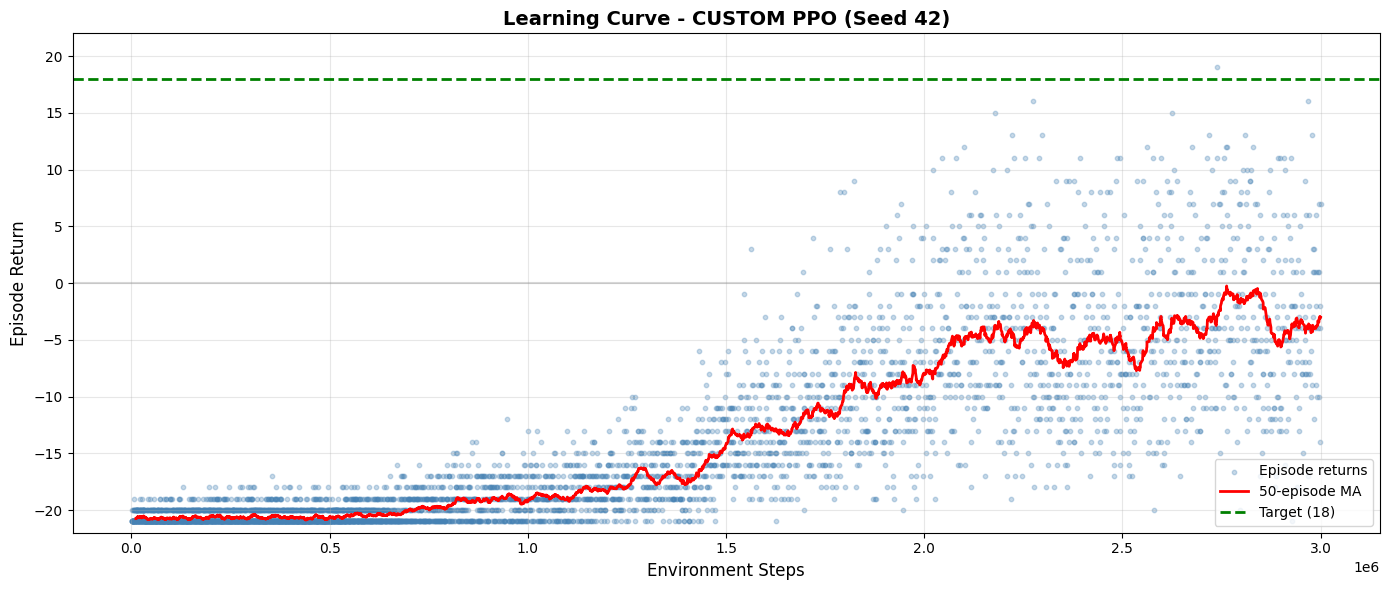

Saved: /content/drive/MyDrive/PPO_Pong_Project_v2/visualizations/custom_eval_seed42.png


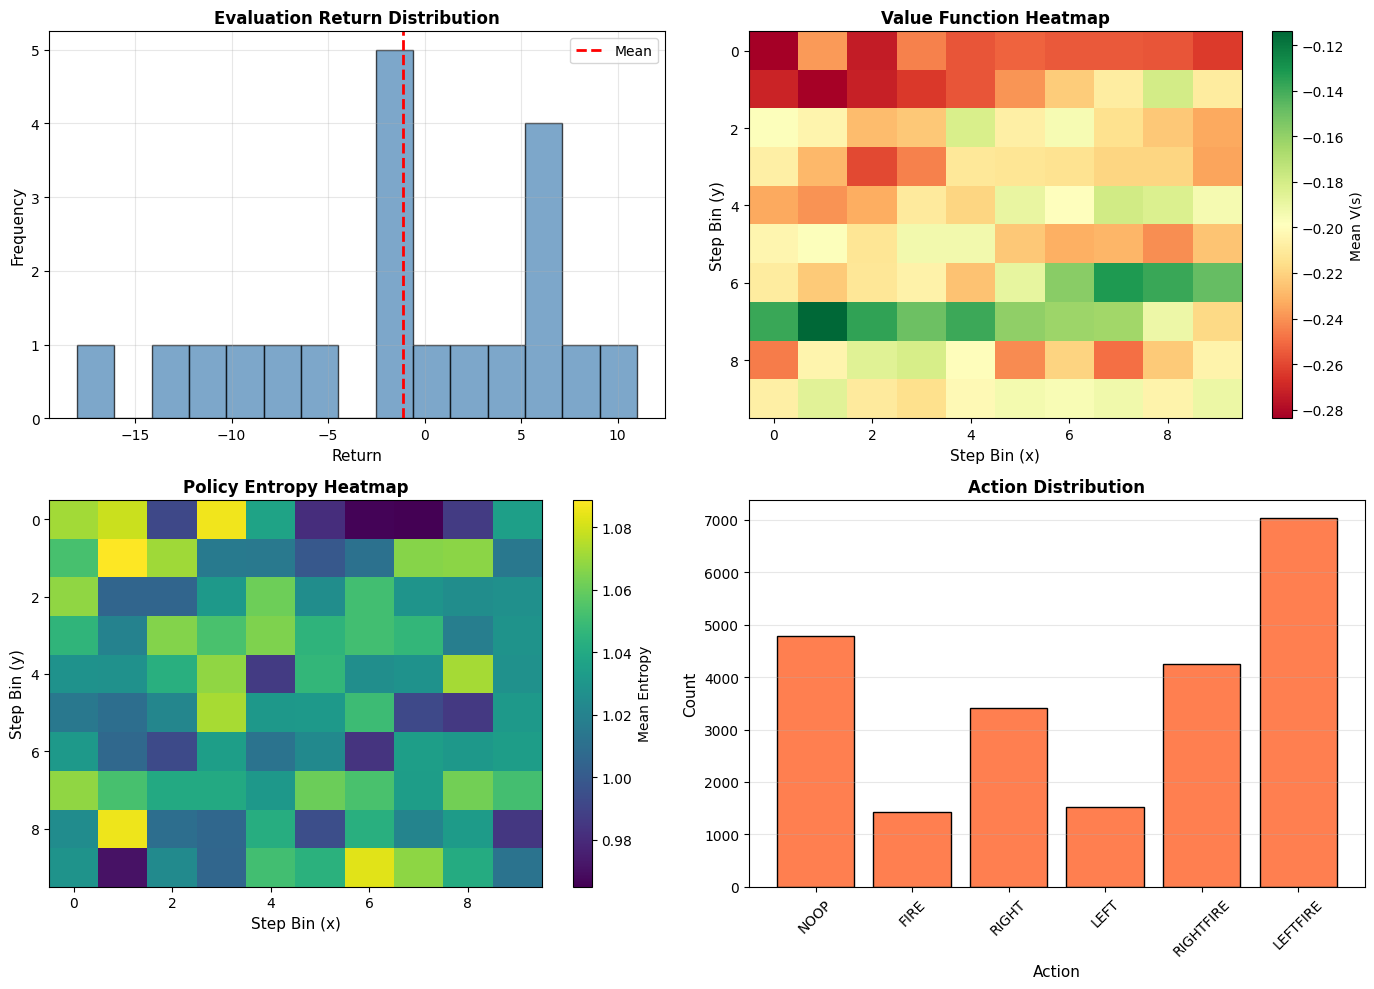

In [ ]:
seed = 42
model_42, path_42, metrics_42 = train_custom_ppo(
    seed=seed,
    total_timesteps=TOTAL_TIMESTEPS,
    n_envs=N_ENVS,
    target_return=TARGET_RETURN,
    experiment_name="custom",
)

eval_42 = evaluate_model_full(path_42, n_episodes=20)
plot_learning_curve(f"{project_dir}/metrics/custom_seed42_metrics.json", 42, "custom")
plot_evaluation_results(eval_42, 42, "custom")

from google.colab import runtime
runtime.unassign()

Training: custom_seed43
Seed: 43 | Timesteps: 3,000,000 | Envs: 8


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py:279: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py:279: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


Using cuda device


/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())


starting training
Logging to /content/drive/MyDrive/PPO_Pong_Project_v2/logs/custom_seed43/PPO_1


Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Streaming output truncated to the last 5000 lines.
|    value_loss           | 0.138        |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 760          |
|    ep_rew_mean          | -18.1        |
| time/                   |              |
|    fps                  | 280          |
|    iterations           | 901          |
|    time_elapsed         | 3285         |
|    total_timesteps      | 922624       |
| train/                  |              |
|    approx_kl            | 0.0030449347 |
|    clip_fraction        | 0.106        |
|    clip_range           | 0.0961       |
|    entropy_loss         | -0.954       |
|    explained_variance   | 0.643        |
|    learning_rate        | 0.00025      |
|    loss                 | 0.0285       |
|    n_updates            | 3600         |
|    policy_gradient_loss | -0.00517     |
|    value_loss           | 0.134        |
---

Early stopping at step 3 due to reaching max kl: 0.02

Streaming output truncated to the last 5000 lines.
|    value_loss           | 0.21        |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 935          |
|    ep_rew_mean          | -9.51        |
| time/                   |              |
|    fps                  | 283          |
|    iterations           | 1849         |
|    time_elapsed         | 6681         |
|    total_timesteps      | 1893376      |
| train/                  |              |
|    approx_kl            | 0.0073636035 |
|    clip_fraction        | 0.101        |
|    clip_range           | 0.145        |
|    entropy_loss         | -1.04        |
|    explained_variance   | 0.612        |
|    learning_rate        | 0.00025      |
|    loss                 | 0.0497       |
|    n_updates            | 7392         |
|    policy_gradient_loss | -0.00734     |
|    value_loss           | 0.206        |
-----

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 958         |
|    ep_rew_mean          | -9.95       |
| time/                   |             |
|    fps                  | 283         |
|    iterations           | 2087        |
|    time_elapsed         | 7524        |
|    total_timesteps      | 2137088     |
| train/                  |             |
|    approx_kl            | 0.019343123 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.157       |
|    entropy_loss         | -1.19       |
|    explained_variance   | 0.493       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0871      |
|    n_updates            | 8344        |
|    policy_gradient_loss | -0.00697    |
|    value_loss           | 0.307       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 965   

Early stopping at step 3 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 967         |
|    ep_rew_mean          | -8.38       |
| time/                   |             |
|    fps                  | 283         |
|    iterations           | 2295        |
|    time_elapsed         | 8276        |
|    total_timesteps      | 2350080     |
| train/                  |             |
|    approx_kl            | 0.021202154 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.167       |
|    entropy_loss         | -1.03       |
|    explained_variance   | 0.596       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0796      |
|    n_updates            | 9176        |
|    policy_gradient_loss | -0.0122     |
|    value_loss           | 0.283       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 967   

Early stopping at step 3 due to reaching max kl: 0.02

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.02e+03   |
|    ep_rew_mean          | -7.35      |
| time/                   |            |
|    fps                  | 284        |
|    iterations           | 2418       |
|    time_elapsed         | 8717       |
|    total_timesteps      | 2476032    |
| train/                  |            |
|    approx_kl            | 0.01975435 |
|    clip_fraction        | 0.205      |
|    clip_range           | 0.174      |
|    entropy_loss         | -1.04      |
|    explained_variance   | 0.708      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.0341     |
|    n_updates            | 9668       |
|    policy_gradient_loss | -0.0166    |
|    value_loss           | 0.19       |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+03    |
|    ep_rew_m

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+03    |
|    ep_rew_mean          | -7.8        |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2485        |
|    time_elapsed         | 8958        |
|    total_timesteps      | 2544640     |
| train/                  |             |
|    approx_kl            | 0.019080892 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.177       |
|    entropy_loss         | -1.02       |
|    explained_variance   | 0.656       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0512      |
|    n_updates            | 9936        |
|    policy_gradient_loss | -0.0111     |
|    value_loss           | 0.206       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+

Early stopping at step 3 due to reaching max kl: 0.02

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.03e+03   |
|    ep_rew_mean          | -7.97      |
| time/                   |            |
|    fps                  | 284        |
|    iterations           | 2496       |
|    time_elapsed         | 8998       |
|    total_timesteps      | 2555904    |
| train/                  |            |
|    approx_kl            | 0.01944567 |
|    clip_fraction        | 0.174      |
|    clip_range           | 0.178      |
|    entropy_loss         | -0.996     |
|    explained_variance   | 0.701      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.0373     |
|    n_updates            | 9980       |
|    policy_gradient_loss | -0.0143    |
|    value_loss           | 0.21       |
----------------------------------------


Early stopping at step 2 due to reaching max kl: 0.02

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.03e+03   |
|    ep_rew_mean          | -7.93      |
| time/                   |            |
|    fps                  | 284        |
|    iterations           | 2497       |
|    time_elapsed         | 9001       |
|    total_timesteps      | 2556928    |
| train/                  |            |
|    approx_kl            | 0.01916884 |
|    clip_fraction        | 0.104      |
|    clip_range           | 0.178      |
|    entropy_loss         | -1         |
|    explained_variance   | 0.695      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.0714     |
|    n_updates            | 9983       |
|    policy_gradient_loss | -0.00806   |
|    value_loss           | 0.25       |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+03    |
|    ep_rew_m

Early stopping at step 3 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+03    |
|    ep_rew_mean          | -7.78       |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2508        |
|    time_elapsed         | 9041        |
|    total_timesteps      | 2568192     |
| train/                  |             |
|    approx_kl            | 0.019148694 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.178       |
|    entropy_loss         | -0.994      |
|    explained_variance   | 0.556       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0637      |
|    n_updates            | 10027       |
|    policy_gradient_loss | -0.0146     |
|    value_loss           | 0.281       |
-----------------------------------------


Early stopping at step 2 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+03    |
|    ep_rew_mean          | -8.09       |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2509        |
|    time_elapsed         | 9044        |
|    total_timesteps      | 2569216     |
| train/                  |             |
|    approx_kl            | 0.018148249 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.178       |
|    entropy_loss         | -1.03       |
|    explained_variance   | 0.646       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0989      |
|    n_updates            | 10030       |
|    policy_gradient_loss | -0.0109     |
|    value_loss           | 0.28        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+03    |
|    ep_rew_mean          | -7.71       |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2530        |
|    time_elapsed         | 9119        |
|    total_timesteps      | 2590720     |
| train/                  |             |
|    approx_kl            | 0.015378525 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.179       |
|    entropy_loss         | -1.04       |
|    explained_variance   | 0.7         |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0504      |
|    n_updates            | 10114       |
|    policy_gradient_loss | -0.018      |
|    value_loss           | 0.231       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+03    |
|    ep_rew_mean          | -7.62       |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2537        |
|    time_elapsed         | 9145        |
|    total_timesteps      | 2597888     |
| train/                  |             |
|    approx_kl            | 0.015837766 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.18        |
|    entropy_loss         | -1.06       |
|    explained_variance   | 0.57        |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0745      |
|    n_updates            | 10142       |
|    policy_gradient_loss | -0.0178     |
|    value_loss           | 0.286       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+03    |
|    ep_rew_mean          | -7.7        |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2552        |
|    time_elapsed         | 9198        |
|    total_timesteps      | 2613248     |
| train/                  |             |
|    approx_kl            | 0.017602991 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.181       |
|    entropy_loss         | -1          |
|    explained_variance   | 0.424       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.013       |
|    n_updates            | 10202       |
|    policy_gradient_loss | -0.015      |
|    value_loss           | 0.195       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+03    |
|    ep_rew_mean          | -7.89       |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2555        |
|    time_elapsed         | 9209        |
|    total_timesteps      | 2616320     |
| train/                  |             |
|    approx_kl            | 0.019713981 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.181       |
|    entropy_loss         | -0.994      |
|    explained_variance   | 0.541       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0435      |
|    n_updates            | 10214       |
|    policy_gradient_loss | -0.0192     |
|    value_loss           | 0.271       |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.02e+03

Early stopping at step 2 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+03    |
|    ep_rew_mean          | -7.74       |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2558        |
|    time_elapsed         | 9220        |
|    total_timesteps      | 2619392     |
| train/                  |             |
|    approx_kl            | 0.016446989 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.181       |
|    entropy_loss         | -0.952      |
|    explained_variance   | 0.5         |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0499      |
|    n_updates            | 10225       |
|    policy_gradient_loss | -0.0101     |
|    value_loss           | 0.253       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+03    |
|    ep_rew_mean          | -8.01       |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2569        |
|    time_elapsed         | 9259        |
|    total_timesteps      | 2630656     |
| train/                  |             |
|    approx_kl            | 0.018816294 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.181       |
|    entropy_loss         | -0.952      |
|    explained_variance   | 0.63        |
|    learning_rate        | 0.00025     |
|    loss                 | 0.088       |
|    n_updates            | 10269       |
|    policy_gradient_loss | -0.0172     |
|    value_loss           | 0.268       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+03    |
|    ep_rew_mean          | -7.08       |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2602        |
|    time_elapsed         | 9379        |
|    total_timesteps      | 2664448     |
| train/                  |             |
|    approx_kl            | 0.019011341 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.183       |
|    entropy_loss         | -0.946      |
|    explained_variance   | 0.494       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0583      |
|    n_updates            | 10401       |
|    policy_gradient_loss | -0.0222     |
|    value_loss           | 0.28        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.04e+

Early stopping at step 3 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.04e+03    |
|    ep_rew_mean          | -6.84       |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2610        |
|    time_elapsed         | 9408        |
|    total_timesteps      | 2672640     |
| train/                  |             |
|    approx_kl            | 0.026244955 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.184       |
|    entropy_loss         | -1.01       |
|    explained_variance   | 0.496       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0169      |
|    n_updates            | 10433       |
|    policy_gradient_loss | -0.0154     |
|    value_loss           | 0.215       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.04e+

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+03    |
|    ep_rew_mean          | -7.12       |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2631        |
|    time_elapsed         | 9484        |
|    total_timesteps      | 2694144     |
| train/                  |             |
|    approx_kl            | 0.024647497 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.185       |
|    entropy_loss         | -1.02       |
|    explained_variance   | 0.634       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.026       |
|    n_updates            | 10517       |
|    policy_gradient_loss | -0.0147     |
|    value_loss           | 0.22        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+

Early stopping at step 1 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.04e+03    |
|    ep_rew_mean          | -6.29       |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2671        |
|    time_elapsed         | 9628        |
|    total_timesteps      | 2735104     |
| train/                  |             |
|    approx_kl            | 0.016730836 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.187       |
|    entropy_loss         | -1.04       |
|    explained_variance   | 0.706       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.08        |
|    n_updates            | 10675       |
|    policy_gradient_loss | -0.00689    |
|    value_loss           | 0.211       |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.03e+03

Early stopping at step 3 due to reaching max kl: 0.03

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.03e+03   |
|    ep_rew_mean          | -6.13      |
| time/                   |            |
|    fps                  | 284        |
|    iterations           | 2683       |
|    time_elapsed         | 9671       |
|    total_timesteps      | 2747392    |
| train/                  |            |
|    approx_kl            | 0.01846361 |
|    clip_fraction        | 0.0969     |
|    clip_range           | 0.187      |
|    entropy_loss         | -1.07      |
|    explained_variance   | 0.7        |
|    learning_rate        | 0.00025    |
|    loss                 | 0.0235     |
|    n_updates            | 10723      |
|    policy_gradient_loss | -0.0178    |
|    value_loss           | 0.211      |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.03e+03     |
|    ep_re

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+03    |
|    ep_rew_mean          | -6.03       |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2692        |
|    time_elapsed         | 9703        |
|    total_timesteps      | 2756608     |
| train/                  |             |
|    approx_kl            | 0.018570602 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.188       |
|    entropy_loss         | -1.01       |
|    explained_variance   | 0.588       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0128      |
|    n_updates            | 10759       |
|    policy_gradient_loss | -0.0167     |
|    value_loss           | 0.186       |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.03

Early stopping at step 3 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+03    |
|    ep_rew_mean          | -5.93       |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2698        |
|    time_elapsed         | 9725        |
|    total_timesteps      | 2762752     |
| train/                  |             |
|    approx_kl            | 0.026258588 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.188       |
|    entropy_loss         | -1.06       |
|    explained_variance   | 0.408       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0451      |
|    n_updates            | 10783       |
|    policy_gradient_loss | -0.0139     |
|    value_loss           | 0.238       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.04e+03    |
|    ep_rew_mean          | -6.06       |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2701        |
|    time_elapsed         | 9735        |
|    total_timesteps      | 2765824     |
| train/                  |             |
|    approx_kl            | 0.022980837 |
|    clip_fraction        | 0.0898      |
|    clip_range           | 0.188       |
|    entropy_loss         | -1.03       |
|    explained_variance   | 0.566       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0311      |
|    n_updates            | 10795       |
|    policy_gradient_loss | -0.0141     |
|    value_loss           | 0.16        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.04e+

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+03    |
|    ep_rew_mean          | -6.62       |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2718        |
|    time_elapsed         | 9796        |
|    total_timesteps      | 2783232     |
| train/                  |             |
|    approx_kl            | 0.021372871 |
|    clip_fraction        | 0.17        |
|    clip_range           | 0.189       |
|    entropy_loss         | -0.998      |
|    explained_variance   | 0.581       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.028       |
|    n_updates            | 10863       |
|    policy_gradient_loss | -0.0176     |
|    value_loss           | 0.221       |
-----------------------------------------


Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.04e+03    |
|    ep_rew_mean          | -6.53       |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2720        |
|    time_elapsed         | 9803        |
|    total_timesteps      | 2785280     |
| train/                  |             |
|    approx_kl            | 0.020047117 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.189       |
|    entropy_loss         | -0.994      |
|    explained_variance   | 0.476       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0603      |
|    n_updates            | 10871       |
|    policy_gradient_loss | -0.017      |
|    value_loss           | 0.276       |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.04

Early stopping at step 2 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.04e+03    |
|    ep_rew_mean          | -6.19       |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2753        |
|    time_elapsed         | 9922        |
|    total_timesteps      | 2819072     |
| train/                  |             |
|    approx_kl            | 0.016718375 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.191       |
|    entropy_loss         | -1.02       |
|    explained_variance   | 0.642       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0436      |
|    n_updates            | 11002       |
|    policy_gradient_loss | -0.0142     |
|    value_loss           | 0.228       |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.04e+03

Early stopping at step 3 due to reaching max kl: 0.03

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.05e+03   |
|    ep_rew_mean          | -6.29      |
| time/                   |            |
|    fps                  | 284        |
|    iterations           | 2762       |
|    time_elapsed         | 9954       |
|    total_timesteps      | 2828288    |
| train/                  |            |
|    approx_kl            | 0.02051546 |
|    clip_fraction        | 0.153      |
|    clip_range           | 0.191      |
|    entropy_loss         | -1.01      |
|    explained_variance   | 0.633      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.029      |
|    n_updates            | 11038      |
|    policy_gradient_loss | -0.0201    |
|    value_loss           | 0.217      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+03    |
|    ep_rew_m

Early stopping at step 2 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+03    |
|    ep_rew_mean          | -6.7        |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2765        |
|    time_elapsed         | 9965        |
|    total_timesteps      | 2831360     |
| train/                  |             |
|    approx_kl            | 0.021249458 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.192       |
|    entropy_loss         | -1.05       |
|    explained_variance   | 0.648       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0587      |
|    n_updates            | 11049       |
|    policy_gradient_loss | -0.0133     |
|    value_loss           | 0.217       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+

Early stopping at step 2 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+03    |
|    ep_rew_mean          | -6.75       |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2771        |
|    time_elapsed         | 9986        |
|    total_timesteps      | 2837504     |
| train/                  |             |
|    approx_kl            | 0.016668221 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.192       |
|    entropy_loss         | -1.06       |
|    explained_variance   | 0.734       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.035       |
|    n_updates            | 11072       |
|    policy_gradient_loss | -0.013      |
|    value_loss           | 0.169       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+

Early stopping at step 2 due to reaching max kl: 0.02

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.05e+03   |
|    ep_rew_mean          | -6.99      |
| time/                   |            |
|    fps                  | 284        |
|    iterations           | 2781       |
|    time_elapsed         | 10022      |
|    total_timesteps      | 2847744    |
| train/                  |            |
|    approx_kl            | 0.02311883 |
|    clip_fraction        | 0.143      |
|    clip_range           | 0.192      |
|    entropy_loss         | -1.05      |
|    explained_variance   | 0.568      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.0833     |
|    n_updates            | 11111      |
|    policy_gradient_loss | -0.00603   |
|    value_loss           | 0.24       |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+03    |
|    ep_rew_m

Early stopping at step 3 due to reaching max kl: 0.03

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.04e+03   |
|    ep_rew_mean          | -6.73      |
| time/                   |            |
|    fps                  | 284        |
|    iterations           | 2820       |
|    time_elapsed         | 10162      |
|    total_timesteps      | 2887680    |
| train/                  |            |
|    approx_kl            | 0.02013343 |
|    clip_fraction        | 0.126      |
|    clip_range           | 0.194      |
|    entropy_loss         | -1         |
|    explained_variance   | 0.546      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.0549     |
|    n_updates            | 11267      |
|    policy_gradient_loss | -0.0164    |
|    value_loss           | 0.262      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+03    |
|    ep_rew_m

Early stopping at step 3 due to reaching max kl: 0.02

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.03e+03   |
|    ep_rew_mean          | -6.84      |
| time/                   |            |
|    fps                  | 284        |
|    iterations           | 2822       |
|    time_elapsed         | 10169      |
|    total_timesteps      | 2889728    |
| train/                  |            |
|    approx_kl            | 0.02082731 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.194      |
|    entropy_loss         | -1         |
|    explained_variance   | 0.428      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.0744     |
|    n_updates            | 11275      |
|    policy_gradient_loss | -0.0167    |
|    value_loss           | 0.234      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+03    |
|    ep_rew_m

Early stopping at step 1 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+03    |
|    ep_rew_mean          | -6.77       |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2825        |
|    time_elapsed         | 10180       |
|    total_timesteps      | 2892800     |
| train/                  |             |
|    approx_kl            | 0.015270826 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.195       |
|    entropy_loss         | -0.965      |
|    explained_variance   | 0.613       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0728      |
|    n_updates            | 11285       |
|    policy_gradient_loss | -0.0102     |
|    value_loss           | 0.235       |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.03e+03

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+03    |
|    ep_rew_mean          | -6.96       |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2829        |
|    time_elapsed         | 10194       |
|    total_timesteps      | 2896896     |
| train/                  |             |
|    approx_kl            | 0.020954844 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.195       |
|    entropy_loss         | -0.954      |
|    explained_variance   | 0.546       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0667      |
|    n_updates            | 11301       |
|    policy_gradient_loss | -0.0141     |
|    value_loss           | 0.246       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+

Early stopping at step 2 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.01e+03    |
|    ep_rew_mean          | -7.57       |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2837        |
|    time_elapsed         | 10222       |
|    total_timesteps      | 2905088     |
| train/                  |             |
|    approx_kl            | 0.019240456 |
|    clip_fraction        | 0.0856      |
|    clip_range           | 0.195       |
|    entropy_loss         | -0.94       |
|    explained_variance   | 0.568       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.066       |
|    n_updates            | 11332       |
|    policy_gradient_loss | -0.011      |
|    value_loss           | 0.2         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.01e+

Early stopping at step 2 due to reaching max kl: 0.03

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.02e+03   |
|    ep_rew_mean          | -7.61      |
| time/                   |            |
|    fps                  | 284        |
|    iterations           | 2840       |
|    time_elapsed         | 10233      |
|    total_timesteps      | 2908160    |
| train/                  |            |
|    approx_kl            | 0.01823235 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.195      |
|    entropy_loss         | -0.977     |
|    explained_variance   | 0.497      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.0921     |
|    n_updates            | 11343      |
|    policy_gradient_loss | -0.0127    |
|    value_loss           | 0.266      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.01e+03    |
|    ep_rew_m

Early stopping at step 2 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.01e+03    |
|    ep_rew_mean          | -7.51       |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2858        |
|    time_elapsed         | 10296       |
|    total_timesteps      | 2926592     |
| train/                  |             |
|    approx_kl            | 0.029285593 |
|    clip_fraction        | 0.0977      |
|    clip_range           | 0.196       |
|    entropy_loss         | -0.954      |
|    explained_variance   | 0.535       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0444      |
|    n_updates            | 11414       |
|    policy_gradient_loss | -0.0122     |
|    value_loss           | 0.205       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.01e+

Early stopping at step 3 due to reaching max kl: 0.02

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1.01e+03  |
|    ep_rew_mean          | -7.05     |
| time/                   |           |
|    fps                  | 284       |
|    iterations           | 2863      |
|    time_elapsed         | 10314     |
|    total_timesteps      | 2931712   |
| train/                  |           |
|    approx_kl            | 0.0194618 |
|    clip_fraction        | 0.123     |
|    clip_range           | 0.197     |
|    entropy_loss         | -1        |
|    explained_variance   | 0.584     |
|    learning_rate        | 0.00025   |
|    loss                 | 0.0595    |
|    n_updates            | 11434     |
|    policy_gradient_loss | -0.015    |
|    value_loss           | 0.218     |
---------------------------------------


Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.01e+03    |
|    ep_rew_mean          | -6.81       |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2864        |
|    time_elapsed         | 10318       |
|    total_timesteps      | 2932736     |
| train/                  |             |
|    approx_kl            | 0.019590264 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.197       |
|    entropy_loss         | -0.981      |
|    explained_variance   | 0.684       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0416      |
|    n_updates            | 11438       |
|    policy_gradient_loss | -0.0182     |
|    value_loss           | 0.222       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.01e+

Early stopping at step 2 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.01e+03    |
|    ep_rew_mean          | -6.82       |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2869        |
|    time_elapsed         | 10336       |
|    total_timesteps      | 2937856     |
| train/                  |             |
|    approx_kl            | 0.013540732 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.197       |
|    entropy_loss         | -0.958      |
|    explained_variance   | 0.55        |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0998      |
|    n_updates            | 11457       |
|    policy_gradient_loss | -0.00961    |
|    value_loss           | 0.314       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.01e+

Early stopping at step 3 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+03    |
|    ep_rew_mean          | -5.89       |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2895        |
|    time_elapsed         | 10432       |
|    total_timesteps      | 2964480     |
| train/                  |             |
|    approx_kl            | 0.027931836 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.198       |
|    entropy_loss         | -0.977      |
|    explained_variance   | 0.634       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0553      |
|    n_updates            | 11561       |
|    policy_gradient_loss | -0.0155     |
|    value_loss           | 0.223       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+

Early stopping at step 2 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+03    |
|    ep_rew_mean          | -5.42       |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2908        |
|    time_elapsed         | 10479       |
|    total_timesteps      | 2977792     |
| train/                  |             |
|    approx_kl            | 0.025948284 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.199       |
|    entropy_loss         | -1          |
|    explained_variance   | 0.582       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.112       |
|    n_updates            | 11612       |
|    policy_gradient_loss | -0.00852    |
|    value_loss           | 0.328       |
-----------------------------------------


Early stopping at step 2 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+03    |
|    ep_rew_mean          | -5.29       |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2909        |
|    time_elapsed         | 10482       |
|    total_timesteps      | 2978816     |
| train/                  |             |
|    approx_kl            | 0.017071903 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.199       |
|    entropy_loss         | -0.992      |
|    explained_variance   | 0.631       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0606      |
|    n_updates            | 11615       |
|    policy_gradient_loss | -0.0105     |
|    value_loss           | 0.267       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+03    |
|    ep_rew_mean          | -5.09       |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2914        |
|    time_elapsed         | 10501       |
|    total_timesteps      | 2983936     |
| train/                  |             |
|    approx_kl            | 0.021922022 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.199       |
|    entropy_loss         | -0.977      |
|    explained_variance   | 0.672       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.00576     |
|    n_updates            | 11635       |
|    policy_gradient_loss | -0.0202     |
|    value_loss           | 0.204       |
-----------------------------------------


Early stopping at step 2 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+03    |
|    ep_rew_mean          | -5.07       |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2915        |
|    time_elapsed         | 10504       |
|    total_timesteps      | 2984960     |
| train/                  |             |
|    approx_kl            | 0.019534413 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.199       |
|    entropy_loss         | -0.958      |
|    explained_variance   | 0.45        |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0991      |
|    n_updates            | 11638       |
|    policy_gradient_loss | -0.00867    |
|    value_loss           | 0.309       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+03    |
|    ep_rew_mean          | -5.1        |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2919        |
|    time_elapsed         | 10519       |
|    total_timesteps      | 2989056     |
| train/                  |             |
|    approx_kl            | 0.018418057 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.199       |
|    entropy_loss         | -1.01       |
|    explained_variance   | 0.629       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0561      |
|    n_updates            | 11654       |
|    policy_gradient_loss | -0.0187     |
|    value_loss           | 0.245       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+

Early stopping at step 2 due to reaching max kl: 0.02

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.05e+03   |
|    ep_rew_mean          | -5.09      |
| time/                   |            |
|    fps                  | 284        |
|    iterations           | 2922       |
|    time_elapsed         | 10530      |
|    total_timesteps      | 2992128    |
| train/                  |            |
|    approx_kl            | 0.02126956 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.971     |
|    explained_variance   | 0.473      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.0999     |
|    n_updates            | 11665      |
|    policy_gradient_loss | -0.0175    |
|    value_loss           | 0.308      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+03    |
|    ep_rew_m

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+03    |
|    ep_rew_mean          | -5.07       |
| time/                   |             |
|    fps                  | 284         |
|    iterations           | 2930        |
|    time_elapsed         | 10559       |
|    total_timesteps      | 3000320     |
| train/                  |             |
|    approx_kl            | 0.017156623 |
|    clip_fraction        | 0.0878      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.04       |
|    explained_variance   | 0.631       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.000225    |
|    n_updates            | 11697       |
|    policy_gradient_loss | -0.0179     |
|    value_loss           | 0.167       |
-----------------------------------------


total episodes: 4800

target reached: False

training complete duration: 2:56:00.033310
Model saved to: /content/drive/MyDrive/PPO_Pong_Project_v2/models/custom_seed43/final_model


episode  1/20: Return =  -12.0 | Steps = 749
episode  2/20: Return =    9.0 | Steps = 1044
episode  3/20: Return =   -7.0 | Steps = 1049
episode  4/20: Return =    5.0 | Steps = 1173
episode  5/20: Return =   -1.0 | Steps = 1244
episode  6/20: Return =   -9.0 | Steps = 1052
episode  7/20: Return =   12.0 | Steps = 936
episode  8/20: Return =    8.0 | Steps = 1133
episode  9/20: Return =  -11.0 | Steps = 924
episode 10/20: Return =   -2.0 | Steps = 1293
episode 11/20: Return =  -10.0 | Steps = 974
episode 12/20: Return =    1.0 | Steps = 1361
episode 13/20: Return =    6.0 | Steps = 1126
episode 14/20: Return =    2.0 | Steps = 1208
episode 15/20: Return =    3.0 | Steps = 1221
episode 16/20: Return =    6.0 | Steps = 1107
episode 17/20: Return =   -8.0 | Steps = 1273
episode 18/20: Return =   -6.0 | Steps = 1133
episode 19/20: Return =   -2.0 | Steps = 1180
episode 20/20: Return =    8.0 | Steps = 1058
Evaluation Results (20 episodes):
Mean return: -0.40 ± 7.30
Median return: 0.00
Rang

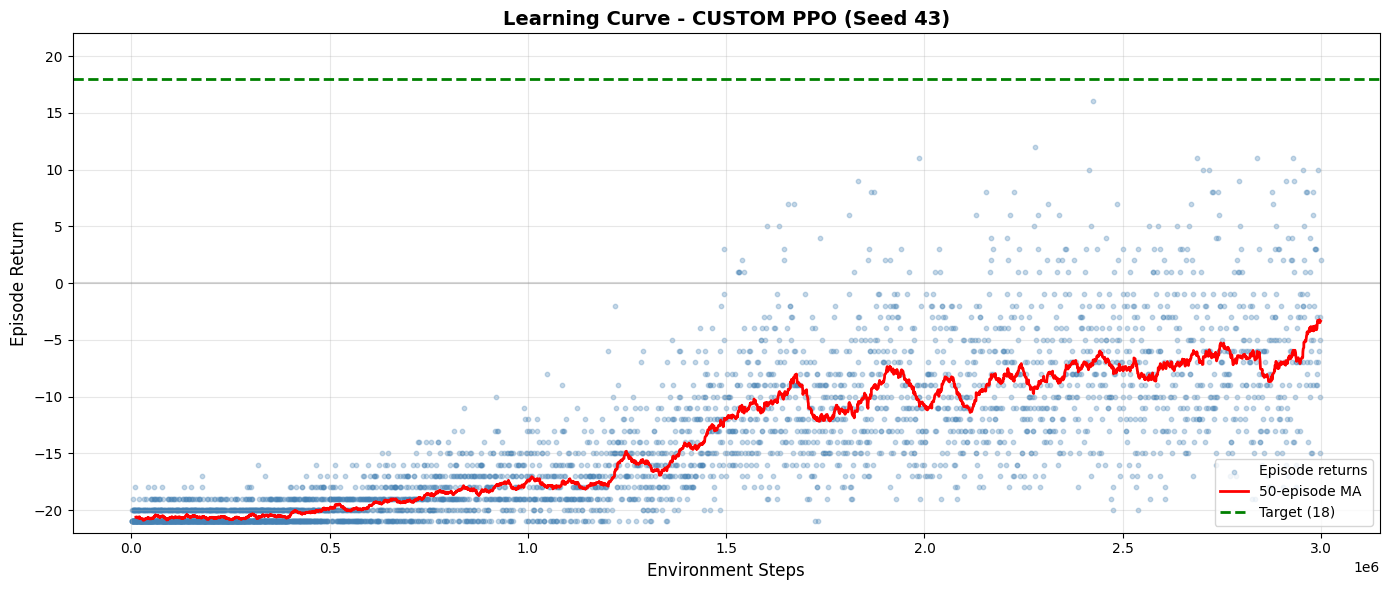

Saved: /content/drive/MyDrive/PPO_Pong_Project_v2/visualizations/custom_eval_seed43.png


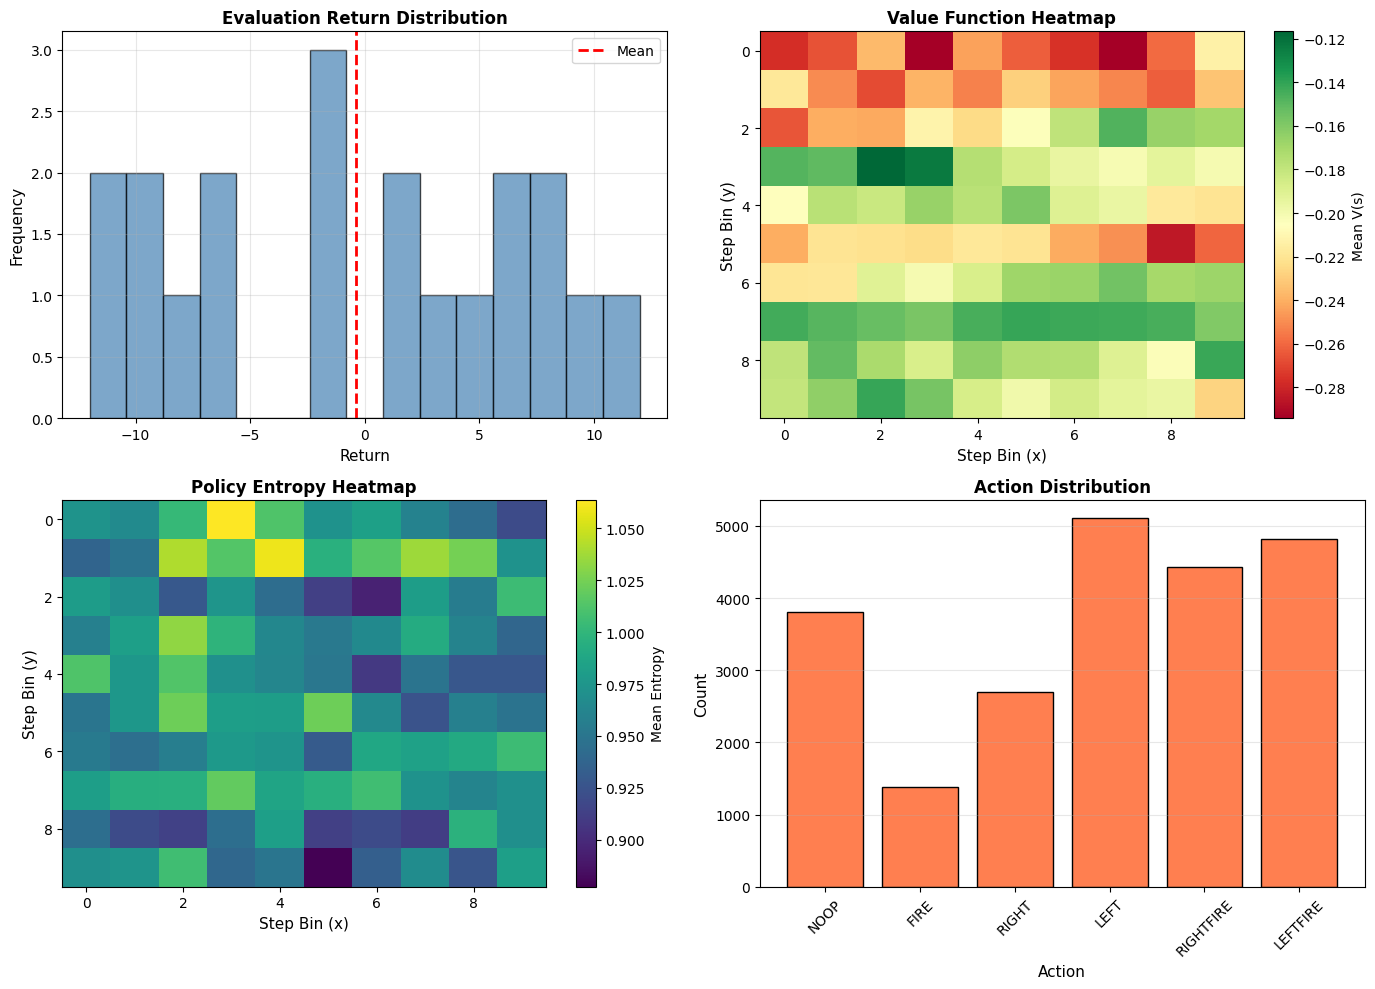

In [ ]:
seed = 43
model_43, path_43, metrics_43 = train_custom_ppo(
    seed=seed,
    total_timesteps=TOTAL_TIMESTEPS,
    n_envs=N_ENVS,
    target_return=TARGET_RETURN,
    experiment_name="custom"
)

eval_43 = evaluate_model_full(f"{project_dir}/models/custom_seed43/final_model", n_episodes=20)
plot_learning_curve(f"{project_dir}/metrics/custom_seed43_metrics.json", 43, "custom")
plot_evaluation_results(eval_43, 43, "custom")

from google.colab import runtime
runtime.unassign()

Training: custom_seed44
Seed: 44 | Timesteps: 3,000,000 | Envs: 8


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py:279: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py:279: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}


Using cuda device


/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())


starting training
Logging to /content/drive/MyDrive/PPO_Pong_Project_v2/logs/custom_seed44/PPO_1


Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.FromDatetime(datetime.datetime.utcnow())
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Streaming output truncated to the last 5000 lines.
|    value_loss           | 0.183       |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 957        |
|    ep_rew_mean          | -10.8      |
| time/                   |            |
|    fps                  | 282        |
|    iterations           | 1841       |
|    time_elapsed         | 6683       |
|    total_timesteps      | 1885184    |
| train/                  |            |
|    approx_kl            | 0.00976408 |
|    clip_fraction        | 0.168      |
|    clip_range           | 0.144      |
|    entropy_loss         | -1.18      |
|    explained_variance   | 0.651      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.0312     |
|    n_updates            | 7360       |
|    policy_gradient_loss | -0.015     |
|    value_loss           | 0.215      |
----------------------------------------
----

Early stopping at step 2 due to reaching max kl: 0.02

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 977        |
|    ep_rew_mean          | -10        |
| time/                   |            |
|    fps                  | 282        |
|    iterations           | 2080       |
|    time_elapsed         | 7544       |
|    total_timesteps      | 2129920    |
| train/                  |            |
|    approx_kl            | 0.01841483 |
|    clip_fraction        | 0.157      |
|    clip_range           | 0.156      |
|    entropy_loss         | -0.93      |
|    explained_variance   | 0.459      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.0629     |
|    n_updates            | 8315       |
|    policy_gradient_loss | -0.00682   |
|    value_loss           | 0.239      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 977         |
|    ep_rew_m

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.01e+03    |
|    ep_rew_mean          | -10.2       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2200        |
|    time_elapsed         | 7978        |
|    total_timesteps      | 2252800     |
| train/                  |             |
|    approx_kl            | 0.016792305 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.163       |
|    entropy_loss         | -1.18       |
|    explained_variance   | 0.406       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0439      |
|    n_updates            | 8795        |
|    policy_gradient_loss | -0.0161     |
|    value_loss           | 0.251       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+

Early stopping at step 3 due to reaching max kl: 0.02

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 971        |
|    ep_rew_mean          | -10.7      |
| time/                   |            |
|    fps                  | 282        |
|    iterations           | 2278       |
|    time_elapsed         | 8257       |
|    total_timesteps      | 2332672    |
| train/                  |            |
|    approx_kl            | 0.01607241 |
|    clip_fraction        | 0.151      |
|    clip_range           | 0.167      |
|    entropy_loss         | -1.14      |
|    explained_variance   | 0.506      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.024      |
|    n_updates            | 9107       |
|    policy_gradient_loss | -0.0169    |
|    value_loss           | 0.175      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 976         |
|    ep_rew_m

Early stopping at step 3 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+03    |
|    ep_rew_mean          | -9.92       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2316        |
|    time_elapsed         | 8394        |
|    total_timesteps      | 2371584     |
| train/                  |             |
|    approx_kl            | 0.021741336 |
|    clip_fraction        | 0.155       |
|    clip_range           | 0.169       |
|    entropy_loss         | -1.1        |
|    explained_variance   | 0.607       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.00861     |
|    n_updates            | 9259        |
|    policy_gradient_loss | -0.0146     |
|    value_loss           | 0.126       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+

Early stopping at step 3 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 983         |
|    ep_rew_mean          | -10.6       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2345        |
|    time_elapsed         | 8496        |
|    total_timesteps      | 2401280     |
| train/                  |             |
|    approx_kl            | 0.020143196 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.17        |
|    entropy_loss         | -1.1        |
|    explained_variance   | 0.471       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.00821     |
|    n_updates            | 9375        |
|    policy_gradient_loss | -0.0161     |
|    value_loss           | 0.184       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 983   

Early stopping at step 2 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 994         |
|    ep_rew_mean          | -10.2       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2370        |
|    time_elapsed         | 8586        |
|    total_timesteps      | 2426880     |
| train/                  |             |
|    approx_kl            | 0.012809577 |
|    clip_fraction        | 0.0817      |
|    clip_range           | 0.171       |
|    entropy_loss         | -1.04       |
|    explained_variance   | 0.529       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0262      |
|    n_updates            | 9474        |
|    policy_gradient_loss | -0.0134     |
|    value_loss           | 0.161       |
-----------------------------------------


Early stopping at step 3 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 998         |
|    ep_rew_mean          | -10.1       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2371        |
|    time_elapsed         | 8589        |
|    total_timesteps      | 2427904     |
| train/                  |             |
|    approx_kl            | 0.021715889 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.171       |
|    entropy_loss         | -1.15       |
|    explained_variance   | 0.563       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.053       |
|    n_updates            | 9478        |
|    policy_gradient_loss | -0.0145     |
|    value_loss           | 0.228       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 998   

Early stopping at step 2 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 996         |
|    ep_rew_mean          | -10.3       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2398        |
|    time_elapsed         | 8686        |
|    total_timesteps      | 2455552     |
| train/                  |             |
|    approx_kl            | 0.017834455 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.173       |
|    entropy_loss         | -1.1        |
|    explained_variance   | 0.485       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0597      |
|    n_updates            | 9585        |
|    policy_gradient_loss | -0.00987    |
|    value_loss           | 0.218       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 996   

Early stopping at step 3 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 997         |
|    ep_rew_mean          | -10.2       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2422        |
|    time_elapsed         | 8773        |
|    total_timesteps      | 2480128     |
| train/                  |             |
|    approx_kl            | 0.024805553 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.174       |
|    entropy_loss         | -1.07       |
|    explained_variance   | 0.499       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0591      |
|    n_updates            | 9681        |
|    policy_gradient_loss | -0.0146     |
|    value_loss           | 0.275       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03 

Early stopping at step 3 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.01e+03    |
|    ep_rew_mean          | -9.75       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2440        |
|    time_elapsed         | 8839        |
|    total_timesteps      | 2498560     |
| train/                  |             |
|    approx_kl            | 0.019013839 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.175       |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.558       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0426      |
|    n_updates            | 9753        |
|    policy_gradient_loss | -0.017      |
|    value_loss           | 0.182       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.01e+

Early stopping at step 3 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.01e+03    |
|    ep_rew_mean          | -9.82       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2442        |
|    time_elapsed         | 8846        |
|    total_timesteps      | 2500608     |
| train/                  |             |
|    approx_kl            | 0.018891033 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.175       |
|    entropy_loss         | -1.07       |
|    explained_variance   | 0.682       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0202      |
|    n_updates            | 9761        |
|    policy_gradient_loss | -0.0205     |
|    value_loss           | 0.183       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+

Early stopping at step 3 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+03    |
|    ep_rew_mean          | -9.81       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2444        |
|    time_elapsed         | 8853        |
|    total_timesteps      | 2502656     |
| train/                  |             |
|    approx_kl            | 0.019593775 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.175       |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.391       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0267      |
|    n_updates            | 9769        |
|    policy_gradient_loss | -0.0116     |
|    value_loss           | 0.175       |
-----------------------------------------


Early stopping at step 3 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+03    |
|    ep_rew_mean          | -9.79       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2445        |
|    time_elapsed         | 8857        |
|    total_timesteps      | 2503680     |
| train/                  |             |
|    approx_kl            | 0.020451872 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.175       |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.478       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0336      |
|    n_updates            | 9773        |
|    policy_gradient_loss | -0.0113     |
|    value_loss           | 0.183       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+

Early stopping at step 3 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+03    |
|    ep_rew_mean          | -9.86       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2477        |
|    time_elapsed         | 8974        |
|    total_timesteps      | 2536448     |
| train/                  |             |
|    approx_kl            | 0.018073434 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.177       |
|    entropy_loss         | -0.931      |
|    explained_variance   | 0.367       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.077       |
|    n_updates            | 9901        |
|    policy_gradient_loss | -0.02       |
|    value_loss           | 0.277       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+03    |
|    ep_rew_mean          | -9.35       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2498        |
|    time_elapsed         | 9049        |
|    total_timesteps      | 2557952     |
| train/                  |             |
|    approx_kl            | 0.016913448 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.178       |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.388       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0479      |
|    n_updates            | 9985        |
|    policy_gradient_loss | -0.0165     |
|    value_loss           | 0.212       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+

Early stopping at step 3 due to reaching max kl: 0.02

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.04e+03   |
|    ep_rew_mean          | -9.54      |
| time/                   |            |
|    fps                  | 282        |
|    iterations           | 2511       |
|    time_elapsed         | 9096       |
|    total_timesteps      | 2571264    |
| train/                  |            |
|    approx_kl            | 0.01835032 |
|    clip_fraction        | 0.148      |
|    clip_range           | 0.179      |
|    entropy_loss         | -0.987     |
|    explained_variance   | 0.47       |
|    learning_rate        | 0.00025    |
|    loss                 | 0.0424     |
|    n_updates            | 10037      |
|    policy_gradient_loss | -0.0186    |
|    value_loss           | 0.243      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.04e+03    |
|    ep_rew_m

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.04e+03    |
|    ep_rew_mean          | -9.45       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2513        |
|    time_elapsed         | 9103        |
|    total_timesteps      | 2573312     |
| train/                  |             |
|    approx_kl            | 0.023198953 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.179       |
|    entropy_loss         | -0.999      |
|    explained_variance   | 0.563       |
|    learning_rate        | 0.00025     |
|    loss                 | -0.00354    |
|    n_updates            | 10045       |
|    policy_gradient_loss | -0.0187     |
|    value_loss           | 0.158       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.04e+

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+03    |
|    ep_rew_mean          | -9.19       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2520        |
|    time_elapsed         | 9128        |
|    total_timesteps      | 2580480     |
| train/                  |             |
|    approx_kl            | 0.017727075 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.179       |
|    entropy_loss         | -0.941      |
|    explained_variance   | 0.577       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0126      |
|    n_updates            | 10073       |
|    policy_gradient_loss | -0.0172     |
|    value_loss           | 0.129       |
-----------------------------------------


Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+03    |
|    ep_rew_mean          | -9.19       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2521        |
|    time_elapsed         | 9131        |
|    total_timesteps      | 2581504     |
| train/                  |             |
|    approx_kl            | 0.019503841 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.179       |
|    entropy_loss         | -0.931      |
|    explained_variance   | 0.572       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0324      |
|    n_updates            | 10077       |
|    policy_gradient_loss | -0.0209     |
|    value_loss           | 0.222       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+

Early stopping at step 3 due to reaching max kl: 0.02

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.07e+03   |
|    ep_rew_mean          | -8.99      |
| time/                   |            |
|    fps                  | 282        |
|    iterations           | 2527       |
|    time_elapsed         | 9153       |
|    total_timesteps      | 2587648    |
| train/                  |            |
|    approx_kl            | 0.01835313 |
|    clip_fraction        | 0.151      |
|    clip_range           | 0.179      |
|    entropy_loss         | -0.943     |
|    explained_variance   | 0.57       |
|    learning_rate        | 0.00025    |
|    loss                 | 0.0346     |
|    n_updates            | 10101      |
|    policy_gradient_loss | -0.0204    |
|    value_loss           | 0.222      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.08e+03    |
|    ep_rew_m

Early stopping at step 2 due to reaching max kl: 0.03

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.08e+03   |
|    ep_rew_mean          | -8.97      |
| time/                   |            |
|    fps                  | 282        |
|    iterations           | 2537       |
|    time_elapsed         | 9188       |
|    total_timesteps      | 2597888    |
| train/                  |            |
|    approx_kl            | 0.01920841 |
|    clip_fraction        | 0.126      |
|    clip_range           | 0.18       |
|    entropy_loss         | -1.01      |
|    explained_variance   | 0.525      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.0474     |
|    n_updates            | 10140      |
|    policy_gradient_loss | -0.0128    |
|    value_loss           | 0.198      |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.07e+03   |
|    ep_rew_mean

Early stopping at step 2 due to reaching max kl: 0.02

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.07e+03   |
|    ep_rew_mean          | -9.01      |
| time/                   |            |
|    fps                  | 282        |
|    iterations           | 2539       |
|    time_elapsed         | 9195       |
|    total_timesteps      | 2599936    |
| train/                  |            |
|    approx_kl            | 0.01928819 |
|    clip_fraction        | 0.137      |
|    clip_range           | 0.18       |
|    entropy_loss         | -1.03      |
|    explained_variance   | 0.596      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.0209     |
|    n_updates            | 10147      |
|    policy_gradient_loss | -0.0162    |
|    value_loss           | 0.158      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.07e+03    |
|    ep_rew_m

Early stopping at step 3 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.07e+03    |
|    ep_rew_mean          | -9.04       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2542        |
|    time_elapsed         | 9206        |
|    total_timesteps      | 2603008     |
| train/                  |             |
|    approx_kl            | 0.020690411 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.18        |
|    entropy_loss         | -1.01       |
|    explained_variance   | 0.454       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0251      |
|    n_updates            | 10159       |
|    policy_gradient_loss | -0.0197     |
|    value_loss           | 0.183       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.07e+

Early stopping at step 3 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.08e+03    |
|    ep_rew_mean          | -8.72       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2550        |
|    time_elapsed         | 9234        |
|    total_timesteps      | 2611200     |
| train/                  |             |
|    approx_kl            | 0.020205382 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.181       |
|    entropy_loss         | -1.06       |
|    explained_variance   | 0.458       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0313      |
|    n_updates            | 10191       |
|    policy_gradient_loss | -0.0139     |
|    value_loss           | 0.215       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.08e+

Early stopping at step 2 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.08e+03    |
|    ep_rew_mean          | -8.7        |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2553        |
|    time_elapsed         | 9245        |
|    total_timesteps      | 2614272     |
| train/                  |             |
|    approx_kl            | 0.018788729 |
|    clip_fraction        | 0.0953      |
|    clip_range           | 0.181       |
|    entropy_loss         | -1.04       |
|    explained_variance   | 0.487       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0429      |
|    n_updates            | 10202       |
|    policy_gradient_loss | -0.0112     |
|    value_loss           | 0.205       |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.08e+03

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.09e+03    |
|    ep_rew_mean          | -8.42       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2564        |
|    time_elapsed         | 9284        |
|    total_timesteps      | 2625536     |
| train/                  |             |
|    approx_kl            | 0.015369696 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.181       |
|    entropy_loss         | -1.03       |
|    explained_variance   | 0.518       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0544      |
|    n_updates            | 10246       |
|    policy_gradient_loss | -0.0196     |
|    value_loss           | 0.268       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.09e+

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.08e+03    |
|    ep_rew_mean          | -8.71       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2591        |
|    time_elapsed         | 9380        |
|    total_timesteps      | 2653184     |
| train/                  |             |
|    approx_kl            | 0.017053884 |
|    clip_fraction        | 0.169       |
|    clip_range           | 0.183       |
|    entropy_loss         | -0.989      |
|    explained_variance   | 0.512       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0273      |
|    n_updates            | 10354       |
|    policy_gradient_loss | -0.0203     |
|    value_loss           | 0.202       |
-----------------------------------------


Early stopping at step 2 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.08e+03    |
|    ep_rew_mean          | -8.74       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2592        |
|    time_elapsed         | 9384        |
|    total_timesteps      | 2654208     |
| train/                  |             |
|    approx_kl            | 0.016802622 |
|    clip_fraction        | 0.0909      |
|    clip_range           | 0.183       |
|    entropy_loss         | -1.01       |
|    explained_variance   | 0.464       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0264      |
|    n_updates            | 10357       |
|    policy_gradient_loss | -0.0109     |
|    value_loss           | 0.177       |
-----------------------------------------


Early stopping at step 2 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.08e+03    |
|    ep_rew_mean          | -8.74       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2593        |
|    time_elapsed         | 9388        |
|    total_timesteps      | 2655232     |
| train/                  |             |
|    approx_kl            | 0.019408623 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.183       |
|    entropy_loss         | -1.07       |
|    explained_variance   | 0.627       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0293      |
|    n_updates            | 10360       |
|    policy_gradient_loss | -0.00921    |
|    value_loss           | 0.165       |
-----------------------------------------


Early stopping at step 3 due to reaching max kl: 0.03

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.08e+03     |
|    ep_rew_mean          | -8.74        |
| time/                   |              |
|    fps                  | 282          |
|    iterations           | 2594         |
|    time_elapsed         | 9391         |
|    total_timesteps      | 2656256      |
| train/                  |              |
|    approx_kl            | 0.0138605945 |
|    clip_fraction        | 0.103        |
|    clip_range           | 0.183        |
|    entropy_loss         | -1.06        |
|    explained_variance   | 0.647        |
|    learning_rate        | 0.00025      |
|    loss                 | 0.0137       |
|    n_updates            | 10364        |
|    policy_gradient_loss | -0.0167      |
|    value_loss           | 0.164        |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

Early stopping at step 2 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.08e+03    |
|    ep_rew_mean          | -8.28       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2611        |
|    time_elapsed         | 9453        |
|    total_timesteps      | 2673664     |
| train/                  |             |
|    approx_kl            | 0.022533953 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.184       |
|    entropy_loss         | -1.06       |
|    explained_variance   | 0.582       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0357      |
|    n_updates            | 10431       |
|    policy_gradient_loss | -0.00818    |
|    value_loss           | 0.201       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.08e+

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+03    |
|    ep_rew_mean          | -8.93       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2628        |
|    time_elapsed         | 9515        |
|    total_timesteps      | 2691072     |
| train/                  |             |
|    approx_kl            | 0.018689927 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.185       |
|    entropy_loss         | -1.04       |
|    explained_variance   | 0.566       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0515      |
|    n_updates            | 10499       |
|    policy_gradient_loss | -0.0179     |
|    value_loss           | 0.227       |
-----------------------------------------


Early stopping at step 2 due to reaching max kl: 0.02

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.05e+03   |
|    ep_rew_mean          | -8.93      |
| time/                   |            |
|    fps                  | 282        |
|    iterations           | 2629       |
|    time_elapsed         | 9519       |
|    total_timesteps      | 2692096    |
| train/                  |            |
|    approx_kl            | 0.02252133 |
|    clip_fraction        | 0.0807     |
|    clip_range           | 0.185      |
|    entropy_loss         | -0.983     |
|    explained_variance   | 0.597      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.0595     |
|    n_updates            | 10502      |
|    policy_gradient_loss | -0.00869   |
|    value_loss           | 0.21       |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.04e+03    |
|    ep_rew_m

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+03    |
|    ep_rew_mean          | -9.35       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2637        |
|    time_elapsed         | 9548        |
|    total_timesteps      | 2700288     |
| train/                  |             |
|    approx_kl            | 0.018659769 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.185       |
|    entropy_loss         | -0.98       |
|    explained_variance   | 0.51        |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0802      |
|    n_updates            | 10534       |
|    policy_gradient_loss | -0.0192     |
|    value_loss           | 0.303       |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.03

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+03    |
|    ep_rew_mean          | -9.41       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2641        |
|    time_elapsed         | 9562        |
|    total_timesteps      | 2704384     |
| train/                  |             |
|    approx_kl            | 0.018574381 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.185       |
|    entropy_loss         | -0.944      |
|    explained_variance   | 0.566       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0318      |
|    n_updates            | 10550       |
|    policy_gradient_loss | -0.0179     |
|    value_loss           | 0.196       |
-----------------------------------------


Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+03    |
|    ep_rew_mean          | -9.48       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2642        |
|    time_elapsed         | 9565        |
|    total_timesteps      | 2705408     |
| train/                  |             |
|    approx_kl            | 0.019756777 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.185       |
|    entropy_loss         | -0.955      |
|    explained_variance   | 0.481       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0783      |
|    n_updates            | 10554       |
|    policy_gradient_loss | -0.016      |
|    value_loss           | 0.23        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+

Early stopping at step 2 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+03    |
|    ep_rew_mean          | -9.34       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2645        |
|    time_elapsed         | 9576        |
|    total_timesteps      | 2708480     |
| train/                  |             |
|    approx_kl            | 0.021384217 |
|    clip_fraction        | 0.0902      |
|    clip_range           | 0.185       |
|    entropy_loss         | -0.943      |
|    explained_variance   | 0.636       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0299      |
|    n_updates            | 10565       |
|    policy_gradient_loss | -0.012      |
|    value_loss           | 0.163       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+

Early stopping at step 1 due to reaching max kl: 0.02

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.03e+03   |
|    ep_rew_mean          | -9.12      |
| time/                   |            |
|    fps                  | 282        |
|    iterations           | 2653       |
|    time_elapsed         | 9605       |
|    total_timesteps      | 2716672    |
| train/                  |            |
|    approx_kl            | 0.01989541 |
|    clip_fraction        | 0.142      |
|    clip_range           | 0.186      |
|    entropy_loss         | -0.977     |
|    explained_variance   | 0.619      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.0831     |
|    n_updates            | 10595      |
|    policy_gradient_loss | -0.00409   |
|    value_loss           | 0.221      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+03    |
|    ep_rew_m

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+03    |
|    ep_rew_mean          | -9.13       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2667        |
|    time_elapsed         | 9656        |
|    total_timesteps      | 2731008     |
| train/                  |             |
|    approx_kl            | 0.017334467 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.186       |
|    entropy_loss         | -0.981      |
|    explained_variance   | 0.553       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0298      |
|    n_updates            | 10651       |
|    policy_gradient_loss | -0.0191     |
|    value_loss           | 0.191       |
-----------------------------------------


Early stopping at step 3 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+03    |
|    ep_rew_mean          | -9.06       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2668        |
|    time_elapsed         | 9659        |
|    total_timesteps      | 2732032     |
| train/                  |             |
|    approx_kl            | 0.028285906 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.187       |
|    entropy_loss         | -0.971      |
|    explained_variance   | 0.389       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0273      |
|    n_updates            | 10655       |
|    policy_gradient_loss | -0.0165     |
|    value_loss           | 0.222       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+

Early stopping at step 2 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+03    |
|    ep_rew_mean          | -9.22       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2674        |
|    time_elapsed         | 9681        |
|    total_timesteps      | 2738176     |
| train/                  |             |
|    approx_kl            | 0.017507644 |
|    clip_fraction        | 0.0909      |
|    clip_range           | 0.187       |
|    entropy_loss         | -0.974      |
|    explained_variance   | 0.609       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.025       |
|    n_updates            | 10678       |
|    policy_gradient_loss | -0.00821    |
|    value_loss           | 0.129       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.04e+

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.04e+03    |
|    ep_rew_mean          | -8.99       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2676        |
|    time_elapsed         | 9688        |
|    total_timesteps      | 2740224     |
| train/                  |             |
|    approx_kl            | 0.023570826 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.187       |
|    entropy_loss         | -0.992      |
|    explained_variance   | 0.379       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0508      |
|    n_updates            | 10686       |
|    policy_gradient_loss | -0.014      |
|    value_loss           | 0.257       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.04e+

Early stopping at step 3 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+03    |
|    ep_rew_mean          | -8.55       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2687        |
|    time_elapsed         | 9728        |
|    total_timesteps      | 2751488     |
| train/                  |             |
|    approx_kl            | 0.018528529 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.188       |
|    entropy_loss         | -0.948      |
|    explained_variance   | 0.337       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0261      |
|    n_updates            | 10730       |
|    policy_gradient_loss | -0.0191     |
|    value_loss           | 0.224       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+03    |
|    ep_rew_mean          | -8.47       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2691        |
|    time_elapsed         | 9743        |
|    total_timesteps      | 2755584     |
| train/                  |             |
|    approx_kl            | 0.017227514 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.188       |
|    entropy_loss         | -0.999      |
|    explained_variance   | 0.573       |
|    learning_rate        | 0.00025     |
|    loss                 | -0.000733   |
|    n_updates            | 10746       |
|    policy_gradient_loss | -0.0187     |
|    value_loss           | 0.146       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+

Early stopping at step 2 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+03    |
|    ep_rew_mean          | -8.69       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2699        |
|    time_elapsed         | 9772        |
|    total_timesteps      | 2763776     |
| train/                  |             |
|    approx_kl            | 0.017590795 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.188       |
|    entropy_loss         | -0.958      |
|    explained_variance   | 0.482       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0273      |
|    n_updates            | 10777       |
|    policy_gradient_loss | -0.0141     |
|    value_loss           | 0.189       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+03    |
|    ep_rew_mean          | -8.62       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2703        |
|    time_elapsed         | 9786        |
|    total_timesteps      | 2767872     |
| train/                  |             |
|    approx_kl            | 0.023156162 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.188       |
|    entropy_loss         | -0.988      |
|    explained_variance   | 0.521       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0313      |
|    n_updates            | 10793       |
|    policy_gradient_loss | -0.0131     |
|    value_loss           | 0.187       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+

Early stopping at step 2 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+03    |
|    ep_rew_mean          | -9.04       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2714        |
|    time_elapsed         | 9826        |
|    total_timesteps      | 2779136     |
| train/                  |             |
|    approx_kl            | 0.016117563 |
|    clip_fraction        | 0.0696      |
|    clip_range           | 0.189       |
|    entropy_loss         | -0.958      |
|    explained_variance   | 0.48        |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0187      |
|    n_updates            | 10836       |
|    policy_gradient_loss | -0.0111     |
|    value_loss           | 0.137       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+

Early stopping at step 2 due to reaching max kl: 0.02

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.06e+03   |
|    ep_rew_mean          | -8.62      |
| time/                   |            |
|    fps                  | 282        |
|    iterations           | 2724       |
|    time_elapsed         | 9863       |
|    total_timesteps      | 2789376    |
| train/                  |            |
|    approx_kl            | 0.01872912 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.189      |
|    entropy_loss         | -0.985     |
|    explained_variance   | 0.463      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.0345     |
|    n_updates            | 10875      |
|    policy_gradient_loss | -0.0155    |
|    value_loss           | 0.172      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+03    |
|    ep_rew_m

Early stopping at step 3 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+03    |
|    ep_rew_mean          | -8.62       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2726        |
|    time_elapsed         | 9870        |
|    total_timesteps      | 2791424     |
| train/                  |             |
|    approx_kl            | 0.024337532 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.19        |
|    entropy_loss         | -0.998      |
|    explained_variance   | 0.576       |
|    learning_rate        | 0.00025     |
|    loss                 | -0.000502   |
|    n_updates            | 10883       |
|    policy_gradient_loss | -0.019      |
|    value_loss           | 0.182       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+03    |
|    ep_rew_mean          | -8.62       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2728        |
|    time_elapsed         | 9877        |
|    total_timesteps      | 2793472     |
| train/                  |             |
|    approx_kl            | 0.021367945 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.19        |
|    entropy_loss         | -1          |
|    explained_variance   | 0.482       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0359      |
|    n_updates            | 10891       |
|    policy_gradient_loss | -0.0178     |
|    value_loss           | 0.192       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.07e+

Early stopping at step 3 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+03    |
|    ep_rew_mean          | -8.71       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2731        |
|    time_elapsed         | 9888        |
|    total_timesteps      | 2796544     |
| train/                  |             |
|    approx_kl            | 0.028548922 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.19        |
|    entropy_loss         | -0.981      |
|    explained_variance   | 0.506       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0513      |
|    n_updates            | 10903       |
|    policy_gradient_loss | -0.016      |
|    value_loss           | 0.221       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.07e+

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.07e+03    |
|    ep_rew_mean          | -8.53       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2735        |
|    time_elapsed         | 9902        |
|    total_timesteps      | 2800640     |
| train/                  |             |
|    approx_kl            | 0.017557673 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.19        |
|    entropy_loss         | -1.01       |
|    explained_variance   | 0.548       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.00823     |
|    n_updates            | 10919       |
|    policy_gradient_loss | -0.0183     |
|    value_loss           | 0.172       |
-----------------------------------------


Early stopping at step 2 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.08e+03    |
|    ep_rew_mean          | -8.46       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2736        |
|    time_elapsed         | 9906        |
|    total_timesteps      | 2801664     |
| train/                  |             |
|    approx_kl            | 0.017995007 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.19        |
|    entropy_loss         | -0.982      |
|    explained_variance   | 0.583       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0143      |
|    n_updates            | 10922       |
|    policy_gradient_loss | -0.0136     |
|    value_loss           | 0.131       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.08e+

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.1e+03     |
|    ep_rew_mean          | -8.16       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2746        |
|    time_elapsed         | 9942        |
|    total_timesteps      | 2811904     |
| train/                  |             |
|    approx_kl            | 0.020970112 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.191       |
|    entropy_loss         | -1          |
|    explained_variance   | 0.485       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0089      |
|    n_updates            | 10962       |
|    policy_gradient_loss | -0.02       |
|    value_loss           | 0.162       |
-----------------------------------------


Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.1e+03     |
|    ep_rew_mean          | -8.16       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2747        |
|    time_elapsed         | 9946        |
|    total_timesteps      | 2812928     |
| train/                  |             |
|    approx_kl            | 0.024119487 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.191       |
|    entropy_loss         | -1.02       |
|    explained_variance   | 0.491       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0121      |
|    n_updates            | 10966       |
|    policy_gradient_loss | -0.0161     |
|    value_loss           | 0.189       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.1e+0

Early stopping at step 3 due to reaching max kl: 0.02

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.11e+03   |
|    ep_rew_mean          | -8.21      |
| time/                   |            |
|    fps                  | 282        |
|    iterations           | 2754       |
|    time_elapsed         | 9971       |
|    total_timesteps      | 2820096    |
| train/                  |            |
|    approx_kl            | 0.01602756 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.191      |
|    entropy_loss         | -1.04      |
|    explained_variance   | 0.534      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.00783    |
|    n_updates            | 10994      |
|    policy_gradient_loss | -0.0217    |
|    value_loss           | 0.159      |
----------------------------------------


Early stopping at step 3 due to reaching max kl: 0.02

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.1e+03    |
|    ep_rew_mean          | -8.48      |
| time/                   |            |
|    fps                  | 282        |
|    iterations           | 2755       |
|    time_elapsed         | 9975       |
|    total_timesteps      | 2821120    |
| train/                  |            |
|    approx_kl            | 0.01760341 |
|    clip_fraction        | 0.146      |
|    clip_range           | 0.191      |
|    entropy_loss         | -1.06      |
|    explained_variance   | 0.309      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.0423     |
|    n_updates            | 10998      |
|    policy_gradient_loss | -0.019     |
|    value_loss           | 0.259      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.1e+03     |
|    ep_rew_m

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.08e+03    |
|    ep_rew_mean          | -8.88       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2766        |
|    time_elapsed         | 10015       |
|    total_timesteps      | 2832384     |
| train/                  |             |
|    approx_kl            | 0.023363188 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.192       |
|    entropy_loss         | -1.01       |
|    explained_variance   | 0.541       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0431      |
|    n_updates            | 11042       |
|    policy_gradient_loss | -0.0174     |
|    value_loss           | 0.219       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.07e+

Early stopping at step 2 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.07e+03    |
|    ep_rew_mean          | -9.1        |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2771        |
|    time_elapsed         | 10034       |
|    total_timesteps      | 2837504     |
| train/                  |             |
|    approx_kl            | 0.023077637 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.192       |
|    entropy_loss         | -1.06       |
|    explained_variance   | 0.471       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.047       |
|    n_updates            | 11061       |
|    policy_gradient_loss | -0.0159     |
|    value_loss           | 0.231       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.07e+

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+03    |
|    ep_rew_mean          | -9.2        |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2776        |
|    time_elapsed         | 10052       |
|    total_timesteps      | 2842624     |
| train/                  |             |
|    approx_kl            | 0.020900246 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.192       |
|    entropy_loss         | -1.12       |
|    explained_variance   | 0.542       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0391      |
|    n_updates            | 11081       |
|    policy_gradient_loss | -0.0197     |
|    value_loss           | 0.225       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+

Early stopping at step 2 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+03    |
|    ep_rew_mean          | -9.36       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2778        |
|    time_elapsed         | 10060       |
|    total_timesteps      | 2844672     |
| train/                  |             |
|    approx_kl            | 0.019734759 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.192       |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.529       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0292      |
|    n_updates            | 11088       |
|    policy_gradient_loss | -0.0138     |
|    value_loss           | 0.174       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+03    |
|    ep_rew_mean          | -9.37       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2780        |
|    time_elapsed         | 10067       |
|    total_timesteps      | 2846720     |
| train/                  |             |
|    approx_kl            | 0.023590267 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.192       |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.425       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0294      |
|    n_updates            | 11096       |
|    policy_gradient_loss | -0.0166     |
|    value_loss           | 0.199       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+

Early stopping at step 2 due to reaching max kl: 0.02

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.03e+03   |
|    ep_rew_mean          | -9.91      |
| time/                   |            |
|    fps                  | 282        |
|    iterations           | 2789       |
|    time_elapsed         | 10100      |
|    total_timesteps      | 2855936    |
| train/                  |            |
|    approx_kl            | 0.02442012 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.193      |
|    entropy_loss         | -1.03      |
|    explained_variance   | 0.532      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.0489     |
|    n_updates            | 11131      |
|    policy_gradient_loss | -0.0103    |
|    value_loss           | 0.171      |
----------------------------------------


Early stopping at step 2 due to reaching max kl: 0.02

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1.03e+03  |
|    ep_rew_mean          | -9.95     |
| time/                   |           |
|    fps                  | 282       |
|    iterations           | 2790      |
|    time_elapsed         | 10103     |
|    total_timesteps      | 2856960   |
| train/                  |           |
|    approx_kl            | 0.0155485 |
|    clip_fraction        | 0.0881    |
|    clip_range           | 0.193     |
|    entropy_loss         | -1.04     |
|    explained_variance   | 0.372     |
|    learning_rate        | 0.00025   |
|    loss                 | 0.0553    |
|    n_updates            | 11134     |
|    policy_gradient_loss | -0.0107   |
|    value_loss           | 0.19      |
---------------------------------------


Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+03    |
|    ep_rew_mean          | -10         |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2791        |
|    time_elapsed         | 10107       |
|    total_timesteps      | 2857984     |
| train/                  |             |
|    approx_kl            | 0.020728908 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.193       |
|    entropy_loss         | -1.06       |
|    explained_variance   | 0.445       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.00825     |
|    n_updates            | 11138       |
|    policy_gradient_loss | -0.0184     |
|    value_loss           | 0.16        |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.02e+03

Early stopping at step 2 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+03    |
|    ep_rew_mean          | -10.2       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2799        |
|    time_elapsed         | 10136       |
|    total_timesteps      | 2866176     |
| train/                  |             |
|    approx_kl            | 0.013960231 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.193       |
|    entropy_loss         | -1.04       |
|    explained_variance   | 0.388       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0313      |
|    n_updates            | 11169       |
|    policy_gradient_loss | -0.00855    |
|    value_loss           | 0.235       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+

Early stopping at step 3 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.01e+03    |
|    ep_rew_mean          | -10.3       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2804        |
|    time_elapsed         | 10154       |
|    total_timesteps      | 2871296     |
| train/                  |             |
|    approx_kl            | 0.027643178 |
|    clip_fraction        | 0.0956      |
|    clip_range           | 0.194       |
|    entropy_loss         | -1.04       |
|    explained_variance   | 0.635       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.00467     |
|    n_updates            | 11189       |
|    policy_gradient_loss | -0.0198     |
|    value_loss           | 0.157       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.01e+

Early stopping at step 2 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.01e+03    |
|    ep_rew_mean          | -10.2       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2807        |
|    time_elapsed         | 10165       |
|    total_timesteps      | 2874368     |
| train/                  |             |
|    approx_kl            | 0.016794167 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.194       |
|    entropy_loss         | -1.04       |
|    explained_variance   | 0.637       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0757      |
|    n_updates            | 11200       |
|    policy_gradient_loss | -0.0141     |
|    value_loss           | 0.22        |
-----------------------------------------


Early stopping at step 3 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.01e+03    |
|    ep_rew_mean          | -10.2       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2808        |
|    time_elapsed         | 10169       |
|    total_timesteps      | 2875392     |
| train/                  |             |
|    approx_kl            | 0.019910472 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.194       |
|    entropy_loss         | -1.03       |
|    explained_variance   | 0.536       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0265      |
|    n_updates            | 11204       |
|    policy_gradient_loss | -0.0204     |
|    value_loss           | 0.199       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.01e+

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 996         |
|    ep_rew_mean          | -10.7       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2818        |
|    time_elapsed         | 10206       |
|    total_timesteps      | 2885632     |
| train/                  |             |
|    approx_kl            | 0.019372525 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.194       |
|    entropy_loss         | -1.05       |
|    explained_variance   | 0.551       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0472      |
|    n_updates            | 11244       |
|    policy_gradient_loss | -0.0196     |
|    value_loss           | 0.268       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 996   

Early stopping at step 2 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 989         |
|    ep_rew_mean          | -10.7       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2822        |
|    time_elapsed         | 10220       |
|    total_timesteps      | 2889728     |
| train/                  |             |
|    approx_kl            | 0.017268956 |
|    clip_fraction        | 0.0881      |
|    clip_range           | 0.194       |
|    entropy_loss         | -1.05       |
|    explained_variance   | 0.601       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0339      |
|    n_updates            | 11259       |
|    policy_gradient_loss | -0.0152     |
|    value_loss           | 0.191       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 989   

Early stopping at step 3 due to reaching max kl: 0.02

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 982        |
|    ep_rew_mean          | -10.8      |
| time/                   |            |
|    fps                  | 282        |
|    iterations           | 2830       |
|    time_elapsed         | 10249      |
|    total_timesteps      | 2897920    |
| train/                  |            |
|    approx_kl            | 0.01881196 |
|    clip_fraction        | 0.159      |
|    clip_range           | 0.195      |
|    entropy_loss         | -1.11      |
|    explained_variance   | 0.489      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.0408     |
|    n_updates            | 11291      |
|    policy_gradient_loss | -0.0168    |
|    value_loss           | 0.238      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 982         |
|    ep_rew_m

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 983         |
|    ep_rew_mean          | -10.6       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2835        |
|    time_elapsed         | 10268       |
|    total_timesteps      | 2903040     |
| train/                  |             |
|    approx_kl            | 0.018656854 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.195       |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.577       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0366      |
|    n_updates            | 11311       |
|    policy_gradient_loss | -0.0256     |
|    value_loss           | 0.212       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 984   

Early stopping at step 3 due to reaching max kl: 0.02

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 981        |
|    ep_rew_mean          | -10.4      |
| time/                   |            |
|    fps                  | 282        |
|    iterations           | 2842       |
|    time_elapsed         | 10293      |
|    total_timesteps      | 2910208    |
| train/                  |            |
|    approx_kl            | 0.02026754 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.195      |
|    entropy_loss         | -1.06      |
|    explained_variance   | 0.514      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.00648    |
|    n_updates            | 11339      |
|    policy_gradient_loss | -0.0199    |
|    value_loss           | 0.204      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 984         |
|    ep_rew_m

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 984         |
|    ep_rew_mean          | -10.2       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2845        |
|    time_elapsed         | 10304       |
|    total_timesteps      | 2913280     |
| train/                  |             |
|    approx_kl            | 0.017908012 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.196       |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.453       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.00797     |
|    n_updates            | 11351       |
|    policy_gradient_loss | -0.0195     |
|    value_loss           | 0.176       |
-----------------------------------------


Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 982         |
|    ep_rew_mean          | -10.3       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2846        |
|    time_elapsed         | 10308       |
|    total_timesteps      | 2914304     |
| train/                  |             |
|    approx_kl            | 0.018948462 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.196       |
|    entropy_loss         | -1.1        |
|    explained_variance   | 0.6         |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0366      |
|    n_updates            | 11355       |
|    policy_gradient_loss | -0.0171     |
|    value_loss           | 0.192       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 978   

Early stopping at step 3 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 978         |
|    ep_rew_mean          | -10.1       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2855        |
|    time_elapsed         | 10340       |
|    total_timesteps      | 2923520     |
| train/                  |             |
|    approx_kl            | 0.021941187 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.196       |
|    entropy_loss         | -1.01       |
|    explained_variance   | 0.576       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0151      |
|    n_updates            | 11391       |
|    policy_gradient_loss | -0.0199     |
|    value_loss           | 0.185       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 982   

Early stopping at step 2 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 982         |
|    ep_rew_mean          | -10         |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2858        |
|    time_elapsed         | 10351       |
|    total_timesteps      | 2926592     |
| train/                  |             |
|    approx_kl            | 0.018216476 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.196       |
|    entropy_loss         | -1.03       |
|    explained_variance   | 0.565       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0407      |
|    n_updates            | 11402       |
|    policy_gradient_loss | -0.015      |
|    value_loss           | 0.181       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 982   

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 982         |
|    ep_rew_mean          | -10         |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2861        |
|    time_elapsed         | 10362       |
|    total_timesteps      | 2929664     |
| train/                  |             |
|    approx_kl            | 0.018853609 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.196       |
|    entropy_loss         | -1.05       |
|    explained_variance   | 0.449       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.00537     |
|    n_updates            | 11414       |
|    policy_gradient_loss | -0.0233     |
|    value_loss           | 0.182       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 982   

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 995         |
|    ep_rew_mean          | -9.62       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2868        |
|    time_elapsed         | 10387       |
|    total_timesteps      | 2936832     |
| train/                  |             |
|    approx_kl            | 0.015410762 |
|    clip_fraction        | 0.0935      |
|    clip_range           | 0.197       |
|    entropy_loss         | -0.974      |
|    explained_variance   | 0.425       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0113      |
|    n_updates            | 11442       |
|    policy_gradient_loss | -0.0226     |
|    value_loss           | 0.173       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 995   

Early stopping at step 2 due to reaching max kl: 0.02

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 997        |
|    ep_rew_mean          | -9.63      |
| time/                   |            |
|    fps                  | 282        |
|    iterations           | 2879       |
|    time_elapsed         | 10426      |
|    total_timesteps      | 2948096    |
| train/                  |            |
|    approx_kl            | 0.01716046 |
|    clip_fraction        | 0.134      |
|    clip_range           | 0.197      |
|    entropy_loss         | -0.977     |
|    explained_variance   | 0.528      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.0442     |
|    n_updates            | 11485      |
|    policy_gradient_loss | -0.0134    |
|    value_loss           | 0.208      |
----------------------------------------


Early stopping at step 1 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 999         |
|    ep_rew_mean          | -9.61       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2880        |
|    time_elapsed         | 10429       |
|    total_timesteps      | 2949120     |
| train/                  |             |
|    approx_kl            | 0.016242072 |
|    clip_fraction        | 0.0859      |
|    clip_range           | 0.197       |
|    entropy_loss         | -0.913      |
|    explained_variance   | 0.406       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0843      |
|    n_updates            | 11487       |
|    policy_gradient_loss | -0.00254    |
|    value_loss           | 0.212       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 999   

Early stopping at step 2 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+03    |
|    ep_rew_mean          | -9.27       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2887        |
|    time_elapsed         | 10454       |
|    total_timesteps      | 2956288     |
| train/                  |             |
|    approx_kl            | 0.019372541 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.198       |
|    entropy_loss         | -0.921      |
|    explained_variance   | 0.579       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0526      |
|    n_updates            | 11514       |
|    policy_gradient_loss | -0.0138     |
|    value_loss           | 0.215       |
-----------------------------------------


Early stopping at step 3 due to reaching max kl: 0.03

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.02e+03   |
|    ep_rew_mean          | -9.27      |
| time/                   |            |
|    fps                  | 282        |
|    iterations           | 2888       |
|    time_elapsed         | 10457      |
|    total_timesteps      | 2957312    |
| train/                  |            |
|    approx_kl            | 0.03046506 |
|    clip_fraction        | 0.0962     |
|    clip_range           | 0.198      |
|    entropy_loss         | -0.896     |
|    explained_variance   | 0.441      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.0581     |
|    n_updates            | 11518      |
|    policy_gradient_loss | -0.0133    |
|    value_loss           | 0.229      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+03    |
|    ep_rew_m

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+03    |
|    ep_rew_mean          | -9.07       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2892        |
|    time_elapsed         | 10472       |
|    total_timesteps      | 2961408     |
| train/                  |             |
|    approx_kl            | 0.015700039 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.198       |
|    entropy_loss         | -0.862      |
|    explained_variance   | 0.596       |
|    learning_rate        | 0.00025     |
|    loss                 | -0.00394    |
|    n_updates            | 11534       |
|    policy_gradient_loss | -0.0154     |
|    value_loss           | 0.138       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.02e+

Early stopping at step 3 due to reaching max kl: 0.02

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.04e+03   |
|    ep_rew_mean          | -8.75      |
| time/                   |            |
|    fps                  | 282        |
|    iterations           | 2906       |
|    time_elapsed         | 10521      |
|    total_timesteps      | 2975744    |
| train/                  |            |
|    approx_kl            | 0.01607218 |
|    clip_fraction        | 0.0955     |
|    clip_range           | 0.199      |
|    entropy_loss         | -0.902     |
|    explained_variance   | 0.586      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.0346     |
|    n_updates            | 11590      |
|    policy_gradient_loss | -0.02      |
|    value_loss           | 0.204      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+03    |
|    ep_rew_m

Early stopping at step 2 due to reaching max kl: 0.02

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.03e+03   |
|    ep_rew_mean          | -8.86      |
| time/                   |            |
|    fps                  | 282        |
|    iterations           | 2908       |
|    time_elapsed         | 10528      |
|    total_timesteps      | 2977792    |
| train/                  |            |
|    approx_kl            | 0.02011109 |
|    clip_fraction        | 0.138      |
|    clip_range           | 0.199      |
|    entropy_loss         | -0.884     |
|    explained_variance   | 0.539      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.0164     |
|    n_updates            | 11597      |
|    policy_gradient_loss | -0.0101    |
|    value_loss           | 0.141      |
----------------------------------------


Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+03    |
|    ep_rew_mean          | -8.83       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2909        |
|    time_elapsed         | 10532       |
|    total_timesteps      | 2978816     |
| train/                  |             |
|    approx_kl            | 0.017220128 |
|    clip_fraction        | 0.0991      |
|    clip_range           | 0.199       |
|    entropy_loss         | -0.893      |
|    explained_variance   | 0.522       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0257      |
|    n_updates            | 11601       |
|    policy_gradient_loss | -0.0162     |
|    value_loss           | 0.196       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.03e+

Early stopping at step 3 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.04e+03    |
|    ep_rew_mean          | -8.79       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2915        |
|    time_elapsed         | 10553       |
|    total_timesteps      | 2984960     |
| train/                  |             |
|    approx_kl            | 0.018057415 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.199       |
|    entropy_loss         | -0.963      |
|    explained_variance   | 0.597       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.00967     |
|    n_updates            | 11625       |
|    policy_gradient_loss | -0.0219     |
|    value_loss           | 0.15        |
-----------------------------------------


Early stopping at step 3 due to reaching max kl: 0.02

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.05e+03   |
|    ep_rew_mean          | -8.71      |
| time/                   |            |
|    fps                  | 282        |
|    iterations           | 2916       |
|    time_elapsed         | 10557      |
|    total_timesteps      | 2985984    |
| train/                  |            |
|    approx_kl            | 0.02058147 |
|    clip_fraction        | 0.152      |
|    clip_range           | 0.199      |
|    entropy_loss         | -0.926     |
|    explained_variance   | 0.531      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.0245     |
|    n_updates            | 11629      |
|    policy_gradient_loss | -0.0213    |
|    value_loss           | 0.174      |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+03    |
|    ep_rew_m

Early stopping at step 2 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+03    |
|    ep_rew_mean          | -8.55       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2919        |
|    time_elapsed         | 10567       |
|    total_timesteps      | 2989056     |
| train/                  |             |
|    approx_kl            | 0.020083372 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.199       |
|    entropy_loss         | -0.912      |
|    explained_variance   | 0.567       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0712      |
|    n_updates            | 11640       |
|    policy_gradient_loss | -0.00765    |
|    value_loss           | 0.231       |
-----------------------------------------


Early stopping at step 3 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+03    |
|    ep_rew_mean          | -8.55       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2920        |
|    time_elapsed         | 10571       |
|    total_timesteps      | 2990080     |
| train/                  |             |
|    approx_kl            | 0.020415636 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.199       |
|    entropy_loss         | -0.921      |
|    explained_variance   | 0.478       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0384      |
|    n_updates            | 11644       |
|    policy_gradient_loss | -0.016      |
|    value_loss           | 0.209       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+

Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+03    |
|    ep_rew_mean          | -8.52       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2923        |
|    time_elapsed         | 10582       |
|    total_timesteps      | 2993152     |
| train/                  |             |
|    approx_kl            | 0.024809446 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.922      |
|    explained_variance   | 0.352       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0778      |
|    n_updates            | 11656       |
|    policy_gradient_loss | -0.0163     |
|    value_loss           | 0.286       |
-----------------------------------------


Early stopping at step 2 due to reaching max kl: 0.02

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.05e+03   |
|    ep_rew_mean          | -8.53      |
| time/                   |            |
|    fps                  | 282        |
|    iterations           | 2924       |
|    time_elapsed         | 10585      |
|    total_timesteps      | 2994176    |
| train/                  |            |
|    approx_kl            | 0.02136229 |
|    clip_fraction        | 0.0836     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.931     |
|    explained_variance   | 0.524      |
|    learning_rate        | 0.00025    |
|    loss                 | 0.0789     |
|    n_updates            | 11659      |
|    policy_gradient_loss | -0.0113    |
|    value_loss           | 0.275      |
----------------------------------------


Early stopping at step 3 due to reaching max kl: 0.02

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+03    |
|    ep_rew_mean          | -8.59       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2925        |
|    time_elapsed         | 10589       |
|    total_timesteps      | 2995200     |
| train/                  |             |
|    approx_kl            | 0.018372862 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.897      |
|    explained_variance   | 0.564       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.00174     |
|    n_updates            | 11663       |
|    policy_gradient_loss | -0.0246     |
|    value_loss           | 0.16        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+

Early stopping at step 3 due to reaching max kl: 0.03

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+03    |
|    ep_rew_mean          | -8.52       |
| time/                   |             |
|    fps                  | 282         |
|    iterations           | 2928        |
|    time_elapsed         | 10599       |
|    total_timesteps      | 2998272     |
| train/                  |             |
|    approx_kl            | 0.019202664 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.932      |
|    explained_variance   | 0.512       |
|    learning_rate        | 0.00025     |
|    loss                 | 0.0401      |
|    n_updates            | 11675       |
|    policy_gradient_loss | -0.0185     |
|    value_loss           | 0.233       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.05e+

total episodes: 4827

target reached: False

training complete duration: 2:56:47.403972
Model saved to: /content/drive/MyDrive/PPO_Pong_Project_v2/models/custom_seed44/final_model


episode  1/20: Return =   -7.0 | Steps = 1198
episode  2/20: Return =  -13.0 | Steps = 865
episode  3/20: Return =   -8.0 | Steps = 1134
episode  4/20: Return =   -8.0 | Steps = 1024
episode  5/20: Return =   -2.0 | Steps = 1250
episode  6/20: Return =   -5.0 | Steps = 1207
episode  7/20: Return =   -5.0 | Steps = 1304
episode  8/20: Return =   -3.0 | Steps = 1426
episode  9/20: Return =   -7.0 | Steps = 1149
episode 10/20: Return =  -13.0 | Steps = 871
episode 11/20: Return =   -5.0 | Steps = 1179
episode 12/20: Return =  -13.0 | Steps = 976
episode 13/20: Return =   -9.0 | Steps = 1160
episode 14/20: Return =   -1.0 | Steps = 1425
episode 15/20: Return =    2.0 | Steps = 1433
episode 16/20: Return =  -14.0 | Steps = 909
episode 17/20: Return =   -4.0 | Steps = 1375
episode 18/20: Return =   -7.0 | Steps = 1079
episode 19/20: Return =   -5.0 | Steps = 1303
episode 20/20: Return =   -1.0 | Steps = 1447
Evaluation Results (20 episodes):
Mean return: -6.40 ± 4.33
Median return: -6.00
Ran

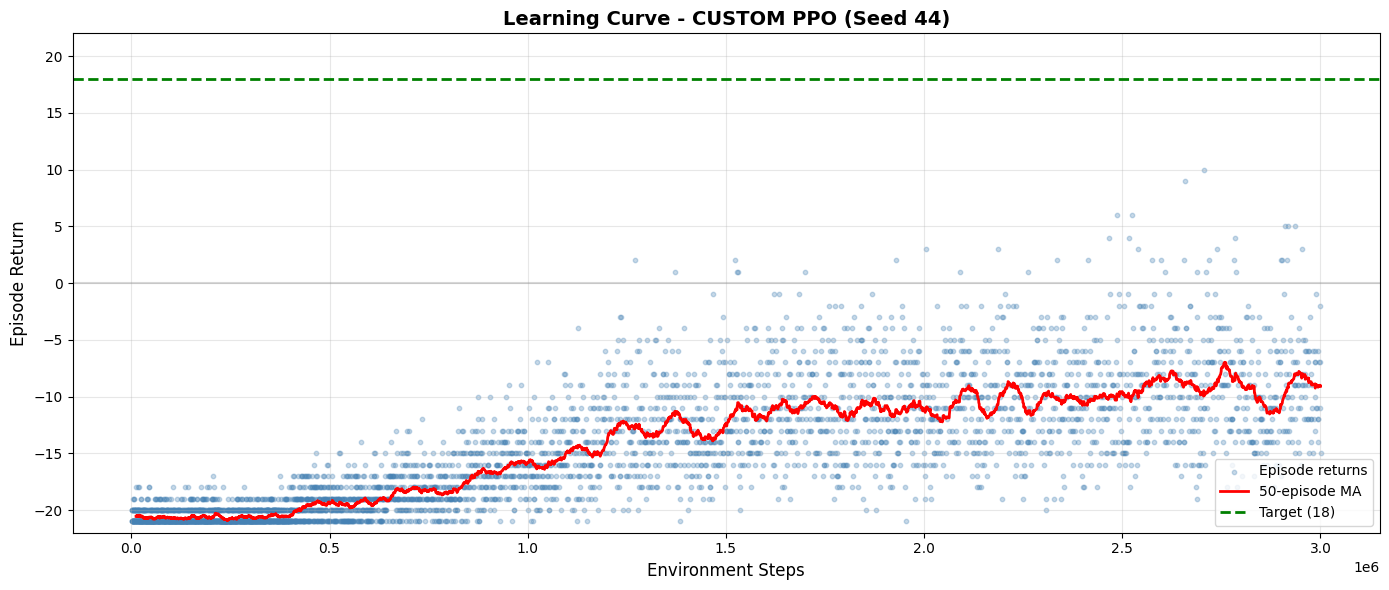

Saved: /content/drive/MyDrive/PPO_Pong_Project_v2/visualizations/custom_eval_seed44.png


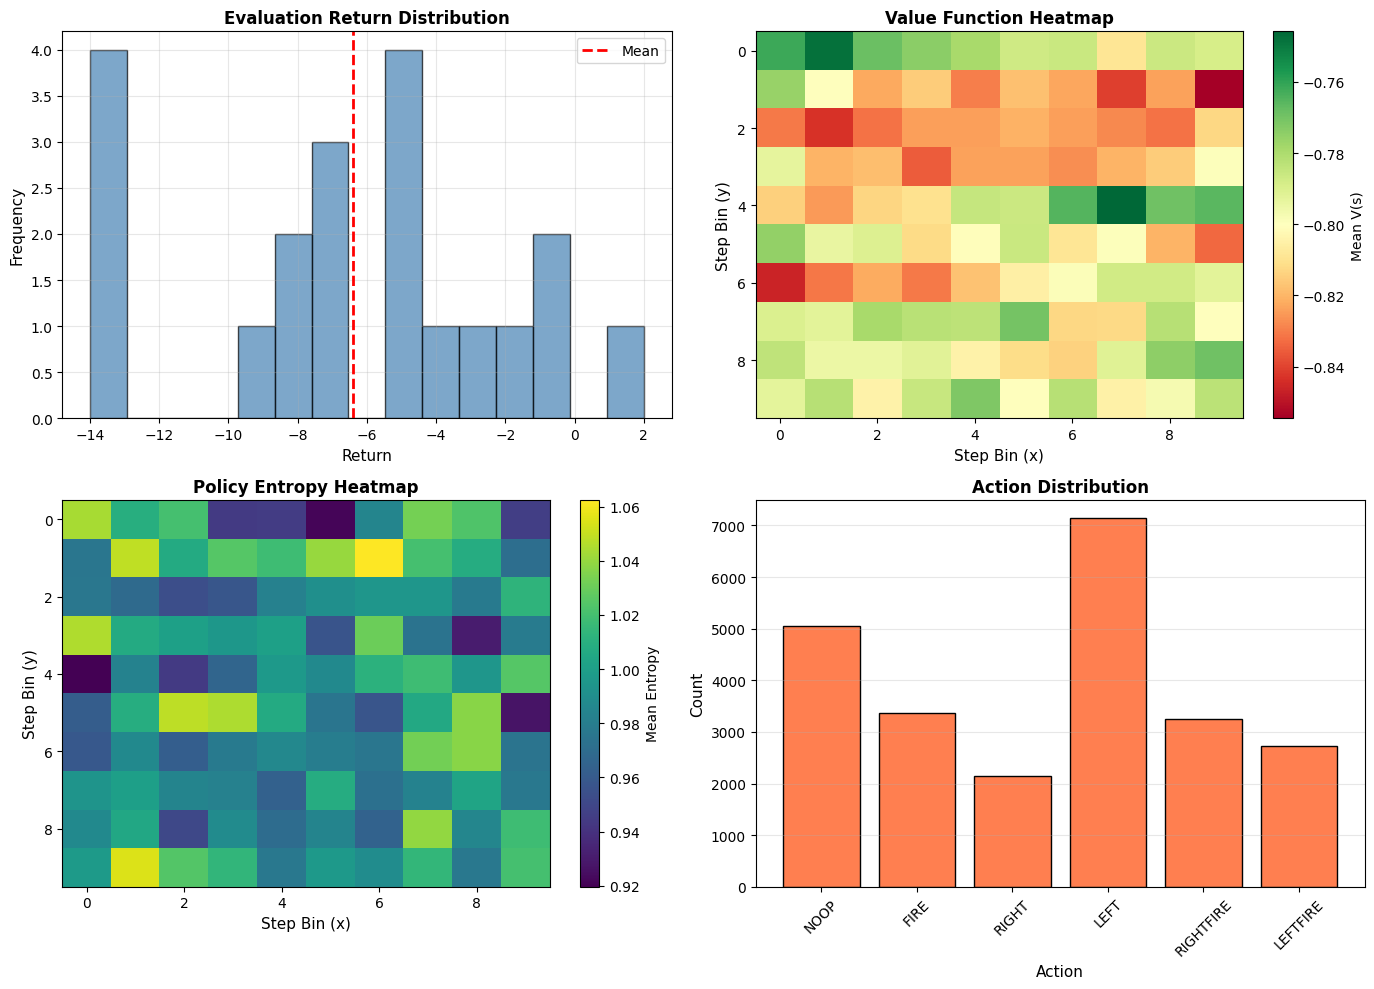

In [ ]:
seed = 44
model_44, path_44, metrics_44 = train_custom_ppo(
    seed=seed,
    total_timesteps=TOTAL_TIMESTEPS,
    n_envs=N_ENVS,
    target_return=TARGET_RETURN,
    experiment_name="custom"
)

eval_44 = evaluate_model_full(path_44, n_episodes=20)
plot_learning_curve(f"{project_dir}/metrics/custom_seed44_metrics.json", 44, "custom")
plot_evaluation_results(eval_44, 44, "custom")

from google.colab import runtime
runtime.unassign()

Saved: /content/drive/MyDrive/PPO_Pong_Project_v2/visualizations/custom_learning_curves_all.png


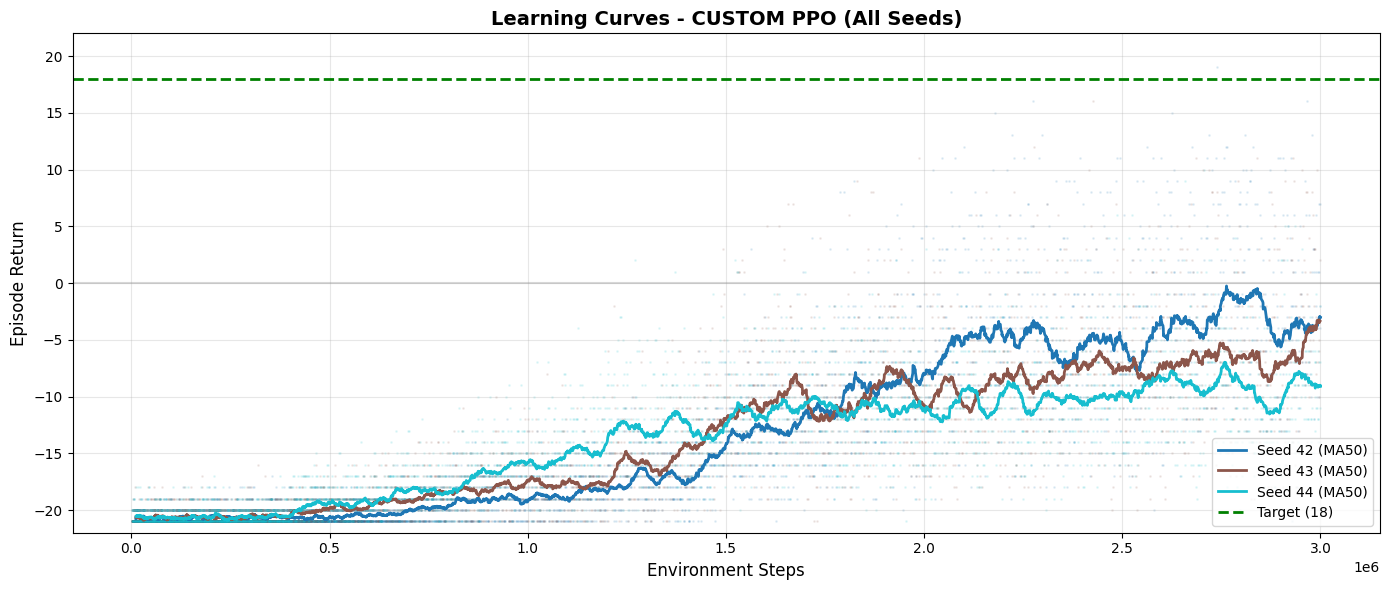

In [ ]:
plot_multi_seed_learning_curves(SEEDS, "custom")

In [ ]:
def aggregate_results(seeds, experiment_name="custom"):
    """
    Aggregate results from multiple seeds and compute statistics.
    """
    all_steps_to_target = []
    all_mean_returns = []

    for seed in seeds:
        metrics_file = f"{project_dir}/metrics/{experiment_name}_seed{seed}_metrics.json"
        if os.path.exists(metrics_file):
            with open(metrics_file, 'r') as f:
                data = json.load(f)

                if data['results']['steps_to_target']:
                    all_steps_to_target.append(data['results']['steps_to_target'])
                all_mean_returns.append(data['results']['mean_return'])

                print(f"Seed {seed}:")
                print(f"Episodes: {data['results']['episodes_completed']}")
                print(f"Mean return: {data['results']['mean_return']:.2f} ± {data['results']['std_return']:.2f}")
                print(f"Target reached: {data['results']['target_reached']}")
                if data['results']['steps_to_target']:
                    print(f"Steps to target: {data['results']['steps_to_target']:,}")

    if all_steps_to_target:
        mean_steps = np.mean(all_steps_to_target)
        std_steps = np.std(all_steps_to_target)
        ci_95 = 1.96 * std_steps / np.sqrt(len(all_steps_to_target))
        print(f"Steps to target: {mean_steps:,.0f} ± {ci_95:,.0f} (95% CI)")
        print(f"Seeds reaching target: {len(all_steps_to_target)}/{len(seeds)}")
    else:
        print("No seeds reached target.")

    print(f"Mean return across seeds: {np.mean(all_mean_returns):.2f} ± {np.std(all_mean_returns):.2f}")

    return {
        'steps_to_target': all_steps_to_target,
        'mean_returns': all_mean_returns,
    }

custom_results = aggregate_results(SEEDS, "custom")

Seed 42:
Episodes: 5624
Mean return: -16.31 ± 7.17
Target reached: True
Steps to target: 2,738,472
Seed 43:
Episodes: 4800
Mean return: -15.88 ± 6.43
Target reached: False
Seed 44:
Episodes: 4827
Mean return: -16.10 ± 5.39
Target reached: False
Steps to target: 2,738,472 ± 0 (95% CI)
Seeds reaching target: 1/3
Mean return across seeds: -16.10 ± 0.18


In [ ]:
def generate_summary_report(seeds, experiment_name="custom"):
    report = []
    report.append(f"PPO on Atari Pong - {experiment_name.upper()} Results")
    report.append(f"Configuration:")
    report.append(f"Seeds: {seeds}")
    report.append(f"Total timesteps: {TOTAL_TIMESTEPS:,}")
    report.append(f"Parallel envs: {N_ENVS}")
    report.append(f"Target return: {TARGET_RETURN}")

    all_steps = []
    all_returns = []

    for seed in seeds:
        metrics_file = f"{project_dir}/metrics/{experiment_name}_seed{seed}_metrics.json"
        if os.path.exists(metrics_file):
            with open(metrics_file, 'r') as f:
                data = json.load(f)

            report.append(f"Seed {seed}:")
            report.append(f"Episodes: {data['results']['episodes_completed']}")
            report.append(f"Mean return: {data['results']['mean_return']:.2f} ± {data['results']['std_return']:.2f}")
            report.append(f"Target reached: {data['results']['target_reached']}")

            if data['results']['steps_to_target']:
                report.append(f"Steps to target: {data['results']['steps_to_target']:,}")
                all_steps.append(data['results']['steps_to_target'])

            all_returns.append(data['results']['mean_return'])


    if all_steps:
        mean_steps = np.mean(all_steps)
        std_steps = np.std(all_steps)
        ci_95 = 1.96 * std_steps / np.sqrt(len(all_steps))
        report.append(f"Steps to target: {mean_steps:,.0f} ± {ci_95:,.0f} (95% CI)")
        report.append(f"Seeds reaching target: {len(all_steps)}/{len(seeds)}")

    report.append(f"Mean return: {np.mean(all_returns):.2f} ± {np.std(all_returns):.2f}")

    report_text = "\n".join(report)
    print(report_text)

    with open(f"{project_dir}/summary_{experiment_name}.txt", 'w') as f:
        f.write(report_text)
    print(f"\nSaved to: {project_dir}/summary_{experiment_name}.txt")

generate_summary_report(SEEDS, "custom")

PPO on Atari Pong - CUSTOM Results
Configuration:
Seeds: [42, 43, 44]
Total timesteps: 3,000,000
Parallel envs: 8
Target return: 18.0
Seed 42:
Episodes: 5624
Mean return: -16.31 ± 7.17
Target reached: True
Steps to target: 2,738,472
Seed 43:
Episodes: 4800
Mean return: -15.88 ± 6.43
Target reached: False
Seed 44:
Episodes: 4827
Mean return: -16.10 ± 5.39
Target reached: False
Steps to target: 2,738,472 ± 0 (95% CI)
Seeds reaching target: 1/3
Mean return: -16.10 ± 0.18

Saved to: /content/drive/MyDrive/PPO_Pong_Project_v2/summary_custom.txt
